In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
print(torch.cuda.is_available())
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import pandas as pd
import copy
from tqdm import tqdm_notebook as tqdm

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

import hierarchy_util
import hierarchy_metrics
import hierarchy_inference
import seaborn as sns
%matplotlib notebook

True


# Loading

In [56]:
# ood_results = torch.load('results/cascade_softpred_fine_pruned-wn_SEED9084345_ITER0_EPOCHS90.result')
fine_val_logits = torch.load('cascade_softpred_fine_pruned-wn_SEED9084345_ITER0_EPOCHS90_vallogits.out')
# ood_logits = torch.load('cascade_softpred_fine_pruned-wn_SEED9084345_ITER0_EPOCHS90_oodlogits.out')
# val_logits = torch.load('coarse_cascadefc3_oe_r2_vallogits.out')
# ood_logits = torch.load('coarse_cascadefc3_oe_r2_oodlogits.out')
# train_logits = torch.load('coarse_cascadefc3_oe_r2_trainlogits.out')
# val_logits = torch.load('coarse_cascadefc3_oe_r1_vallogits.out')
# ood_logits = torch.load('coarse_cascadefc3_oe_r1_oodlogits.out')
# train_logits = torch.load('coarse_cascadefc3_oe_r1_trainlogits.out')
val_logits = torch.load('coarse_cascadefc3_oe_r0_vallogits.out')
ood_logits = torch.load('coarse_cascadefc3_oe_r0_oodlogits.out')
train_logits = torch.load('coarse_cascadefc3_oe_r0_trainlogits.out')
softmax_logits = {}
softmax_logits['val'] = [torch.load('coarse_softmax_r0_vallogits.out'),
                         torch.load('coarse_softmax_r1_vallogits.out'),
                         torch.load('coarse_softmax_r2_vallogits.out')]
softmax_logits['ood'] = [torch.load('coarse_softmax_r0_oodlogits.out'),
                         torch.load('coarse_softmax_r1_oodlogits.out'),
                         torch.load('coarse_softmax_r2_oodlogits.out')]
softmax_logits['train'] = [torch.load('coarse_softmax_r0_trainlogits.out'),
                           torch.load('coarse_softmax_r1_trainlogits.out'),
                           torch.load('coarse_softmax_r2_trainlogits.out')]

In [57]:
val_logits['targets'] = val_logits['targets'].long()
ood_logits['targets'] = ood_logits['targets'].long()
train_logits['targets'] = train_logits['targets'].long()




In [58]:
lm = pd.read_csv('data/label-map.csv', header=None)
fine_id = pd.read_csv('data/fine-id-labels.csv', header=None)
fine_ood = pd.read_csv('data/fine-ood-labels.csv', header=None)
coarse_id = pd.read_csv('data/coarse-id-labels.csv', header=None)
coarse_ood = pd.read_csv('data/coarse-ood-labels.csv', header=None)
pruned_hierarchy_fine = hierarchy_util.Hierarchy(list(lm[0]), hierarchy_fn='pruned-wn.pth')
# id_hierarchy = hierarchy_util.Hierarchy(list(fine_id[0]), hierarchy_fn='pruned-wn.pth')
# ood_hierarchy = hierarchy_util.Hierarchy(list(fine_ood[0]), hierarchy_fn='pruned-wn.pth')
id_hierarchy = hierarchy_util.Hierarchy(list(coarse_id[0]), hierarchy_fn='pruned-wn.pth')
ood_hierarchy = hierarchy_util.Hierarchy(list(coarse_ood[0]), hierarchy_fn='pruned-wn.pth')

In [59]:
coarse_id

0    1                 2
0   n01530575   10         brambling
1   n01531178   11         goldfinch
2   n01532829   12       house finch
3   n01537544   14    indigo bunting
4   n01664065   33        loggerhead
..        ...  ...               ...
78  n12998815  992            agaric
79  n13037406  993         gyromitra
80  n13040303  994         stinkhorn
81  n13044778  995         earthstar
82  n13052670  996  hen-of-the-woods

[83 rows x 3 columns]

# ROC Analysis

## Gather scores

In [60]:
train_ml, train_act = id_hierarchy.to_multilabel(train_logits["targets"].long())
val_ml, val_act = id_hierarchy.to_multilabel(val_logits["targets"].long())
full_ood_ml, full_ood_act = ood_hierarchy.to_full_multilabel(ood_logits["targets"].long())
ood_ml, ood_act = id_hierarchy.trim_full_multilabel(full_ood_ml, full_ood_act)

In [36]:
display(len(full_ood_ml[0]))
display(full_ood_ml[0])
display(full_ood_act[0])
display(len(ood_ml[0]))
display(ood_ml[0])
display(ood_act[0])

29

tensor([1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 3])

tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

25

tensor([1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.])

tensor([1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.])

In [37]:
train_hlogits = id_hierarchy.split_logits_by_synset(train_logits['logits'])
val_hlogits = id_hierarchy.split_logits_by_synset(val_logits['logits'])
ood_hlogits = id_hierarchy.split_logits_by_synset(ood_logits['logits'])

In [38]:
train_pred_bscores, train_pred_oscores, train_preds, train_bentropy_data, train_oentropy_data, train_entropy_idxs = \
    hierarchy_metrics.soft_predict(train_hlogits, id_hierarchy, 'cascade', T=1000.)

val_pred_bscores, val_pred_oscores, val_preds, val_bentropy_data, val_oentropy_data, val_entropy_idxs = \
    hierarchy_metrics.soft_predict(val_hlogits, id_hierarchy, 'cascade', T=1000.)

ood_pred_bscores, ood_pred_oscores, ood_preds, ood_bentropy_data, ood_oentropy_data, ood_entropy_idxs = \
    hierarchy_metrics.soft_predict(ood_hlogits, id_hierarchy, 'cascade', T=1000.)

In [39]:
train_pred_hbscores, train_pred_hoscores, train_synset_bentropy, train_synset_oentropy = \
    hierarchy_metrics.gather_soft_scores(train_hlogits, id_hierarchy, 'cascade', T=1000.)
val_pred_hbscores, val_pred_hoscores, val_synset_bentropy, val_synset_oentropy = \
    hierarchy_metrics.gather_soft_scores(val_hlogits, id_hierarchy, 'cascade', T=1000.)
ood_pred_hbscores, ood_pred_hoscores, ood_synset_bentropy, ood_synset_oentropy = \
    hierarchy_metrics.gather_soft_scores(ood_hlogits, id_hierarchy, 'cascade', T=1000.)

## ID Micro ROC

<IPython.core.display.Javascript object>


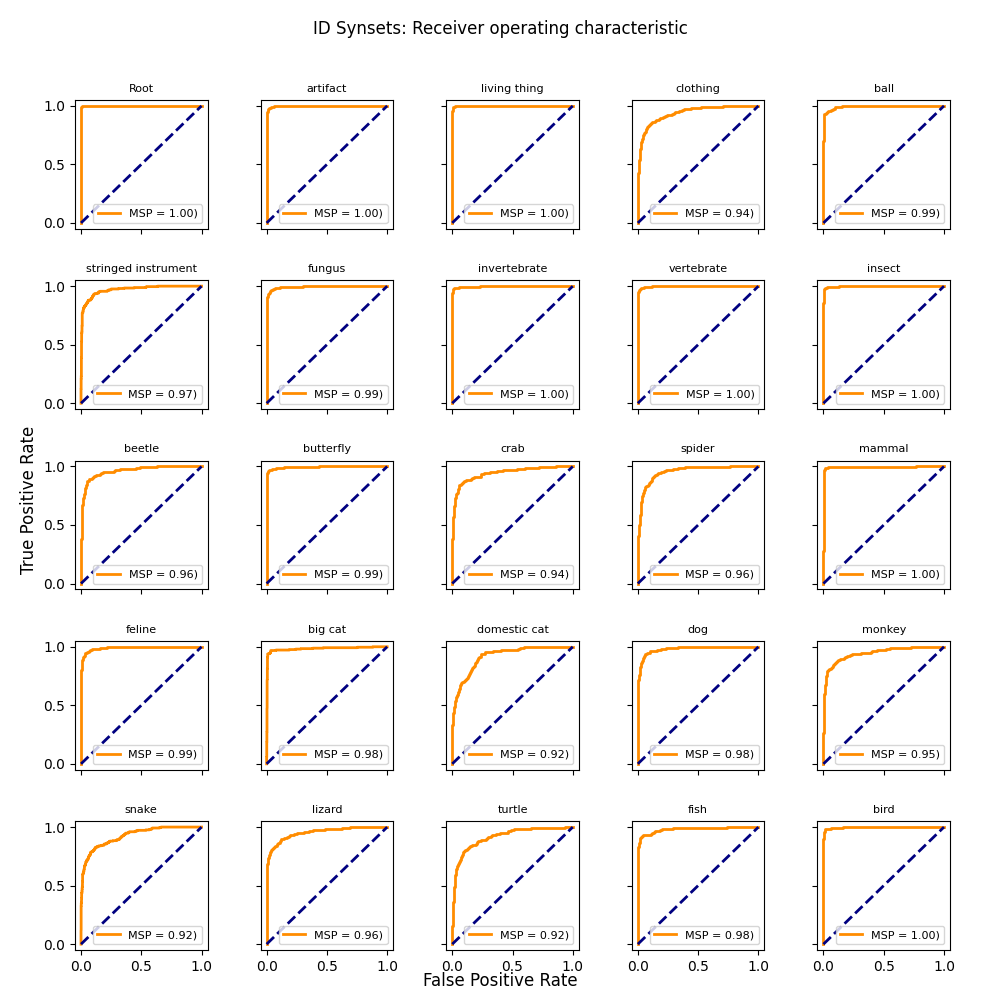

(4150, 2)
torch.Size([4150, 2])
(750, 3)
torch.Size([750, 3])
(3400, 3)
torch.Size([3400, 3])
(250, 5)
torch.Size([250, 5])
(250, 5)
torch.Size([250, 5])
(250, 5)
torch.Size([250, 5])
(250, 5)
torch.Size([250, 5])
(1000, 3)
torch.Size([1000, 3])
(2150, 6)
torch.Size([2150, 6])
(500, 2)
torch.Size([500, 2])
(250, 5)
torch.Size([250, 5])
(250, 5)
torch.Size([250, 5])
(250, 5)
torch.Size([250, 5])
(250, 5)
torch.Size([250, 5])
(950, 3)
torch.Size([950, 3])
(500, 2)
torch.Size([500, 2])
(250, 5)
torch.Size([250, 5])
(250, 5)
torch.Size([250, 5])
(200, 4)
torch.Size([200, 4])
(250, 5)
torch.Size([250, 5])
(250, 5)
torch.Size([250, 5])
(250, 5)
torch.Size([250, 5])
(250, 5)
torch.Size([250, 5])
(250, 5)
torch.Size([250, 5])
(200, 4)
torch.Size([200, 4])


In [253]:
fig, axs = plt.subplots(5,5,sharex='all', sharey='all', figsize=(10,10))
curr_axs = 0
fig.supxlabel('False Positive Rate')
fig.supylabel('True Positive Rate')
fig.suptitle('ID Synsets: Receiver operating characteristic')
# fig.tight_layout()
plt.subplots_adjust(left=0.075, bottom=0.05, right=0.95, top=0.9, wspace=0.4, hspace=0.4)

ID_FPR, ID_TPR, ID_AUC = [], [], []
for i,end_idx in enumerate(id_hierarchy.synset_bounds):
    # Gather active synsets
#     active_synset_idxs = (train_act[:,i] == 1)
#     synset_gt = (train_ml[active_synset_idxs])[:,i]
    active_synset_idxs = (val_act[:,i] == 1)
    synset_gt = (val_ml[active_synset_idxs])[:,i]
#     synset_bsoftpreds = train_pred_hbscores[i][active_synset_idxs]
    synset_bsoftpreds = val_pred_hbscores[i][active_synset_idxs]
#     synset_osoftpreds = val_pred_hoscores[i][active_synset_idxs]
    synset_gtroc = np.zeros((synset_gt.size(0), end_idx-int(id_hierarchy.synset_offsets[i])+1), dtype=int)
    for j in range(synset_gtroc.shape[1]):
        synset_gtroc[:,j] = (synset_gt[:]==j).cpu().numpy()
    print(synset_gtroc.shape)
    print(synset_bsoftpreds.size())
    b_fpr, b_tpr, _ = roc_curve(synset_gtroc.ravel(),
                                synset_bsoftpreds.cpu().numpy().ravel())
    broc_auc = auc(b_fpr, b_tpr)
#     o_fpr, o_tpr, _ = roc_curve(synset_gtroc.ravel(),
#                                 synset_osoftpreds.cpu().numpy().ravel())
#     oroc_auc = auc(o_fpr, o_tpr)
    ID_FPR.append(b_fpr)
    ID_TPR.append(b_tpr)
    ID_AUC.append(broc_auc)
    lw = 2
    ax = axs.ravel()[i]
    ax.plot(b_fpr, b_tpr, color='darkorange',
         lw=lw, label='MSP = %0.2f)' % broc_auc)
#     ax.plot(o_fpr, o_tpr, color='darkgreen',
#          lw=lw, label='ODIN = %0.2f)' % oroc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    if id_hierarchy.child2parent[id_hierarchy.class_list[end_idx]] is None:
        synset_name = "Root"
    else:
        synset_name = id_hierarchy.class_description[id_hierarchy.child2parent[id_hierarchy.class_list[end_idx]]]
    ax.set_title(synset_name, fontsize=8)
    ax.legend(loc='lower right', fontsize=8)
plt.show()


## OOD ROC

### ID and all OOD micro ROC

In [22]:
# def plot_allsynset_ROC(
#         figtitle='Synset-wise receiver operating characteristic',
#         subplot_adjust=[0.1, 0.1, 0.9, 0.9, 0.4, 0.4],
#     ):
#     """Plot ROC curve """
#     fig, axs = plt.subplots(6,5,sharex='all', sharey='all', figsize=(10,10))
#     curr_axs = 0
#     fig.supxlabel('False Positive Rate')
#     fig.supylabel('True Positive Rate')
#     fig.suptitle(figtitle)
#     # fig.tight_layout()
#     plt.subplots_adjust(
#         left=subplot_adjust[0],
#         bottom= ,
#         right=,
#         top=,
#         wspace=, 
#         hspace=)
    

<IPython.core.display.Javascript object>


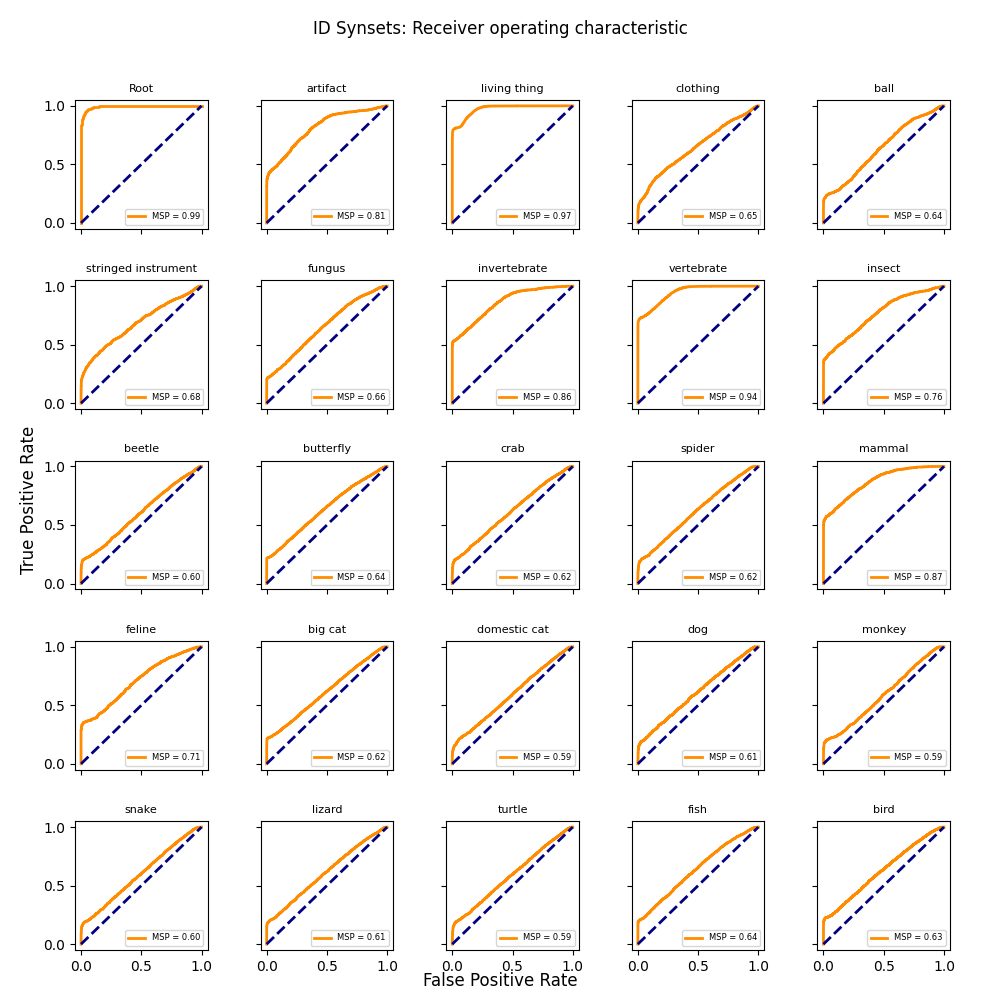

(5000, 2)
torch.Size([5000, 2])
(1600, 3)
torch.Size([1600, 3])
(4250, 3)
torch.Size([4250, 3])
(1100, 5)
torch.Size([1100, 5])
(1100, 5)
torch.Size([1100, 5])
(1100, 5)
torch.Size([1100, 5])
(1100, 5)
torch.Size([1100, 5])
(1850, 3)
torch.Size([1850, 3])
(3000, 6)
torch.Size([3000, 6])
(1350, 2)
torch.Size([1350, 2])
(1100, 5)
torch.Size([1100, 5])
(1100, 5)
torch.Size([1100, 5])
(1100, 5)
torch.Size([1100, 5])
(1100, 5)
torch.Size([1100, 5])
(1800, 3)
torch.Size([1800, 3])
(1350, 2)
torch.Size([1350, 2])
(1100, 5)
torch.Size([1100, 5])
(1100, 5)
torch.Size([1100, 5])
(1050, 4)
torch.Size([1050, 4])
(1100, 5)
torch.Size([1100, 5])
(1100, 5)
torch.Size([1100, 5])
(1100, 5)
torch.Size([1100, 5])
(1100, 5)
torch.Size([1100, 5])
(1100, 5)
torch.Size([1100, 5])
(1050, 4)
torch.Size([1050, 4])


In [254]:
fig, axs = plt.subplots(5,5,sharex='all', sharey='all', figsize=(10,10))
curr_axs = 0
fig.supxlabel('False Positive Rate')
fig.supylabel('True Positive Rate')
fig.suptitle('ID Synsets: Receiver operating characteristic')
# fig.tight_layout()
plt.subplots_adjust(left=0.075, bottom=0.05, right=0.95, top=0.9, wspace=0.4, hspace=0.4)
IDOOD_FPR, IDOOD_TPR, IDOOD_AUC = [], [], []
for i,end_idx in enumerate(id_hierarchy.synset_bounds):
    # Gather active synsets
#     active_synset_idxs = (train_act[:,i] == 1)
#     synset_gt = (train_ml[active_synset_idxs])[:,i]
#     synset_bsoftpreds = train_pred_hbscores[i][active_synset_idxs]
#     synset_osoftpreds = train_pred_hoscores[i][active_synset_idxs]
    active_synset_idxs = (val_act[:,i] == 1)
    synset_gt = (val_ml[active_synset_idxs])[:,i]
    synset_bsoftpreds = val_pred_hbscores[i][active_synset_idxs]
    synset_osoftpreds = val_pred_hoscores[i][active_synset_idxs]
    active_ood_synset_idxs = (ood_act[:,i] != -1)
    synset_ood_gt = (ood_ml[active_ood_synset_idxs])[:,i]
    synset_ood_bsoftpreds = ood_pred_hbscores[i][active_ood_synset_idxs]
    synset_ood_osoftpreds = ood_pred_hoscores[i][active_ood_synset_idxs]
    if synset_ood_bsoftpreds.shape[0] == 0:
        continue
    synset_gt = torch.cat((synset_gt, synset_ood_gt), axis=0)
    synset_bsoftpreds = torch.cat((synset_bsoftpreds, synset_ood_bsoftpreds), axis=0)
    synset_osoftpreds = torch.cat((synset_osoftpreds, synset_ood_osoftpreds), axis=0)
    synset_gtroc = np.zeros((synset_gt.size(0), end_idx-int(id_hierarchy.synset_offsets[i])+1), dtype=int)
    for j in range(synset_gtroc.shape[1]):
        synset_gtroc[:,j] = (synset_gt[:]==j).cpu().numpy()
    print(synset_gtroc.shape)
    print(synset_bsoftpreds.size())
    b_fpr, b_tpr, _ = roc_curve(synset_gtroc.ravel(),
                                synset_bsoftpreds.cpu().numpy().ravel())
    broc_auc = auc(b_fpr, b_tpr)
    IDOOD_FPR.append(b_fpr)
    IDOOD_TPR.append(b_tpr)
    IDOOD_AUC.append(broc_auc)
    o_fpr, o_tpr, _ = roc_curve(synset_gtroc.ravel(),
                                synset_osoftpreds.cpu().numpy().ravel())
    oroc_auc = auc(o_fpr, o_tpr)
    lw = 2
    ax = axs.ravel()[curr_axs]
    curr_axs += 1
    ax.plot(b_fpr, b_tpr, color='darkorange',
         lw=lw, label='MSP = %0.2f' % broc_auc)
#     ax.plot(o_fpr, o_tpr, color='darkgreen',
#          lw=lw, label='ODIN = %0.2f' % oroc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    if id_hierarchy.child2parent[id_hierarchy.class_list[end_idx]] is None:
        synset_name = "Root"
    else:
        synset_name = id_hierarchy.class_description[id_hierarchy.child2parent[id_hierarchy.class_list[end_idx]]]
    ax.set_title(synset_name, fontsize=8)
    ax.legend(loc='lower right', fontsize=6)
plt.show()

### ID and OOD > TNR @ 95 Threshold micro ROC

In [272]:
fig, axs = plt.subplots(5,5,sharex='all', sharey='all', figsize=(10,10))
curr_axs = 0
fig.supxlabel('False Positive Rate')
fig.supylabel('True Positive Rate')
fig.suptitle('ID-OOD Synsets: Receiver operating characteristic')
# fig.tight_layout()
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.3)

IDOODTHRESH_FPR, IDOODTHRESH_TPR, IDOODTHRESH_AUC = [], [], []
for i,end_idx in enumerate(id_hierarchy.synset_bounds):
    # Gather active synsets
    # USE TRAIN TO GET THRESHOLD
    active_synset_idxs = (train_act[:,i] == 1)
    synset_gt = (train_ml[active_synset_idxs])[:,i]
    synset_bsoftpreds = train_pred_hbscores[i][active_synset_idxs]
    synset_osoftpreds = train_pred_hoscores[i][active_synset_idxs]
#     active_synset_idxs = (val_act[:,i] == 1)
#     synset_gt = (val_ml[active_synset_idxs])[:,i]
#     synset_bsoftpreds = val_pred_hbscores[i][active_synset_idxs]
#     synset_osoftpreds = val_pred_hoscores[i][active_synset_idxs]
    synset_gtroc = np.zeros((synset_gt.size(0), end_idx-int(id_hierarchy.synset_offsets[i])+1), dtype=int)
    for j in range(synset_gtroc.shape[1]):
        synset_gtroc[:,j] = (synset_gt[:]==j).cpu().numpy()
    print(synset_gtroc.shape)
    print(synset_bsoftpreds.size())
    b_fpr, b_tpr, b_thresh = roc_curve(synset_gtroc.ravel(),
                                synset_bsoftpreds.cpu().numpy().ravel())
    o_fpr, o_tpr, o_thresh = roc_curve(synset_gtroc.ravel(),
                                synset_osoftpreds.cpu().numpy().ravel())
    b_tpr95idx = np.argmin(np.abs((1-b_fpr)-0.99))
    o_tpr95idx = np.argmin(np.abs((1-o_fpr)-0.99))
    btarg = b_thresh[b_tpr95idx]
    otarg = o_thresh[o_tpr95idx]
    print("btarg {}, otarg {}".format(btarg, otarg))
    
    # Switch to val logits
    active_synset_idxs = (val_act[:,i] == 1)
    synset_gt = (val_ml[active_synset_idxs])[:,i]
    synset_bsoftpreds = val_pred_hbscores[i][active_synset_idxs]
    synset_osoftpreds = val_pred_hoscores[i][active_synset_idxs]
    synset_gtroc = np.zeros((synset_gt.size(0), end_idx-int(id_hierarchy.synset_offsets[i])+1), dtype=int)
    for j in range(synset_gtroc.shape[1]):
        synset_gtroc[:,j] = (synset_gt[:]==j).cpu().numpy()
    
    # Active ood indexs
    active_ood_synset_idxs = (ood_act[:,i] != -1)
    synset_ood_gt = (ood_ml[active_ood_synset_idxs])[:,i]
    synset_ood_bsoftpreds = ood_pred_hbscores[i][active_ood_synset_idxs]
    synset_ood_osoftpreds = ood_pred_hoscores[i][active_ood_synset_idxs]
    if synset_ood_bsoftpreds.shape[0] == 0:
        continue
        
    synset_ood_gtroc = np.zeros((synset_ood_gt.size(0), end_idx-int(id_hierarchy.synset_offsets[i])+1), dtype=int)
    for j in range(synset_ood_gtroc.shape[1]):
        synset_ood_gtroc[:,j] = (synset_ood_gt[:]==j).cpu().numpy()
        
    synset_gtroc = torch.cat((torch.tensor(synset_gtroc), torch.tensor(synset_ood_gtroc)), axis=0).cpu().numpy()
    synset_bsoftpreds = torch.cat((synset_bsoftpreds, synset_ood_bsoftpreds), axis=0)
    synset_osoftpreds = torch.cat((synset_osoftpreds, synset_ood_osoftpreds), axis=0)
    
    synset_bsoftpreds = synset_bsoftpreds.cpu().numpy().ravel()
    synset_osoftpreds = synset_osoftpreds.cpu().numpy().ravel()
    synset_bgt = (synset_gtroc.ravel())[synset_bsoftpreds>=btarg]
    synset_bsoftpreds = synset_bsoftpreds[synset_bsoftpreds>=btarg]
    synset_ogt = (synset_gtroc.ravel())[synset_osoftpreds>=otarg]
    synset_osoftpreds = synset_osoftpreds[synset_osoftpreds>=otarg]
    
    # Recalculate ROCs
    b_fpr, b_tpr, _ = roc_curve(synset_bgt, synset_bsoftpreds)
    o_fpr, o_tpr, _ = roc_curve(synset_ogt, synset_osoftpreds)
    broc_auc = auc(b_fpr, b_tpr)
    oroc_auc = auc(o_fpr, o_tpr)
    
    IDOODTHRESH_FPR.append(b_fpr)
    IDOODTHRESH_TPR.append(b_tpr)
    IDOODTHRESH_AUC.append(broc_auc)
    
    lw = 2
    ax = axs.ravel()[curr_axs]
    curr_axs += 1
    ax.plot(b_fpr, b_tpr, color='darkorange',
         lw=lw, label='MSP = %0.2f' % broc_auc)
#     ax.plot(o_fpr, o_tpr, color='darkgreen',
#          lw=lw, label='ODIN = %0.2f' % oroc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    if id_hierarchy.child2parent[id_hierarchy.class_list[end_idx]] is None:
        synset_name = "Root"
    else:
        synset_name = id_hierarchy.class_description[id_hierarchy.child2parent[id_hierarchy.class_list[end_idx]]]
    ax.set_title(synset_name, fontsize=8)
    ax.legend(loc='lower right', fontsize=6)
plt.show()

<IPython.core.display.Javascript object>

(106872, 2)
torch.Size([106872, 2])
btarg 0.3661237199848326, otarg 0.49986277938233603
(18884, 3)
torch.Size([18884, 3])
btarg 0.38628102263791647, otarg 0.16723049259501516
(87988, 3)
torch.Size([87988, 3])
btarg 0.3226650574147592, otarg 0.16751331654247573
(5884, 5)
torch.Size([5884, 5])
btarg 0.47532512629253265, otarg 0.033880918846285135
(6500, 5)
torch.Size([6500, 5])
btarg 0.3789998764348474, otarg 0.03396895324623678
(6500, 5)
torch.Size([6500, 5])
btarg 0.5012802282623027, otarg 0.03399804844726935
(6500, 5)
torch.Size([6500, 5])
btarg 0.3846774086954669, otarg 0.033948654655093884
(26000, 3)
torch.Size([26000, 3])
btarg 0.21259370091112287, otarg 0.056445246501169395
(55488, 6)
torch.Size([55488, 6])
btarg 0.11780596217149045, otarg 0.028381217109219037
(13000, 2)
torch.Size([13000, 2])
btarg 0.2653961976753804, otarg 0.028447197869633203
(6500, 5)
torch.Size([6500, 5])
btarg 0.5387132456876922, otarg 0.005784311496259137
(6500, 5)
torch.Size([6500, 5])
btarg 0.245235314591

In [273]:
# (4150, 2)
# torch.Size([4150, 2])
# btarg 0.04076948535582934, otarg 0.49921045127571956
# (750, 3)
# torch.Size([750, 3])
# btarg 0.07423409072293954, otarg 0.16713037872817263
# (3400, 3)
# torch.Size([3400, 3])
# btarg 0.018646365176825653, otarg 0.1673343240211476
# (250, 5)
# torch.Size([250, 5])
# btarg 0.3165421329642707, otarg 0.03378656767771156
# (250, 5)
# torch.Size([250, 5])
# btarg 0.0988711719681512, otarg 0.03387913150104061
# (250, 5)
# torch.Size([250, 5])
# btarg 0.22488055209675162, otarg 0.033875178626927446
# (250, 5)
# torch.Size([250, 5])
# btarg 0.05382879704710672, otarg 0.033887857389531484
# (1000, 3)
# torch.Size([1000, 3])
# btarg 0.04666371243810556, otarg 0.05634217871734304
# (2150, 6)
# torch.Size([2150, 6])
# btarg 0.023031786630746315, otarg 0.028249748559443462
# (500, 2)
# torch.Size([500, 2])
# btarg 0.03317630451475544, otarg 0.028379594763170174
# (250, 5)
# torch.Size([250, 5])
# btarg 0.2095201727002233, otarg 0.0057476032046629355
# (250, 5)
# torch.Size([250, 5])
# btarg 0.059522850308570185, otarg 0.005740821816523634
# (250, 5)
# torch.Size([250, 5])
# btarg 0.2546184958298461, otarg 0.011428176826101788
# (250, 5)
# torch.Size([250, 5])
# btarg 0.4219301367342891, otarg 0.011444766225814142
# (950, 3)
# torch.Size([950, 3])
# btarg 0.017078199040302538, otarg 0.009536055538987127
# (500, 2)
# torch.Size([500, 2])
# btarg 0.263774853650653, otarg 0.004809091962124596
# (250, 5)
# torch.Size([250, 5])
# btarg 0.047171316962546214, otarg 0.0009721038824900713
# (250, 5)
# torch.Size([250, 5])
# btarg 0.4932882703624893, otarg 0.0009714880683955025
# (200, 4)
# torch.Size([200, 4])
# btarg 0.2614199655137105, otarg 0.0024131077980780805
# (250, 5)
# torch.Size([250, 5])
# btarg 0.2530544636220303, otarg 0.0019474377200756749
# (250, 5)
# torch.Size([250, 5])
# btarg 0.33755712802755766, otarg 0.005752592224076033
# (250, 5)
# torch.Size([250, 5])
# btarg 0.14673977675100222, otarg 0.005725140273490122
# (250, 5)
# torch.Size([250, 5])
# btarg 0.4160340197453361, otarg 0.005778528800140392
# (250, 5)
# torch.Size([250, 5])
# btarg 0.03937233506629663, otarg 0.005732334311781714
# (200, 4)
# torch.Size([200, 4])
# btarg 0.036650600112423715, otarg 0.007143708417118571

<IPython.core.display.Javascript object>


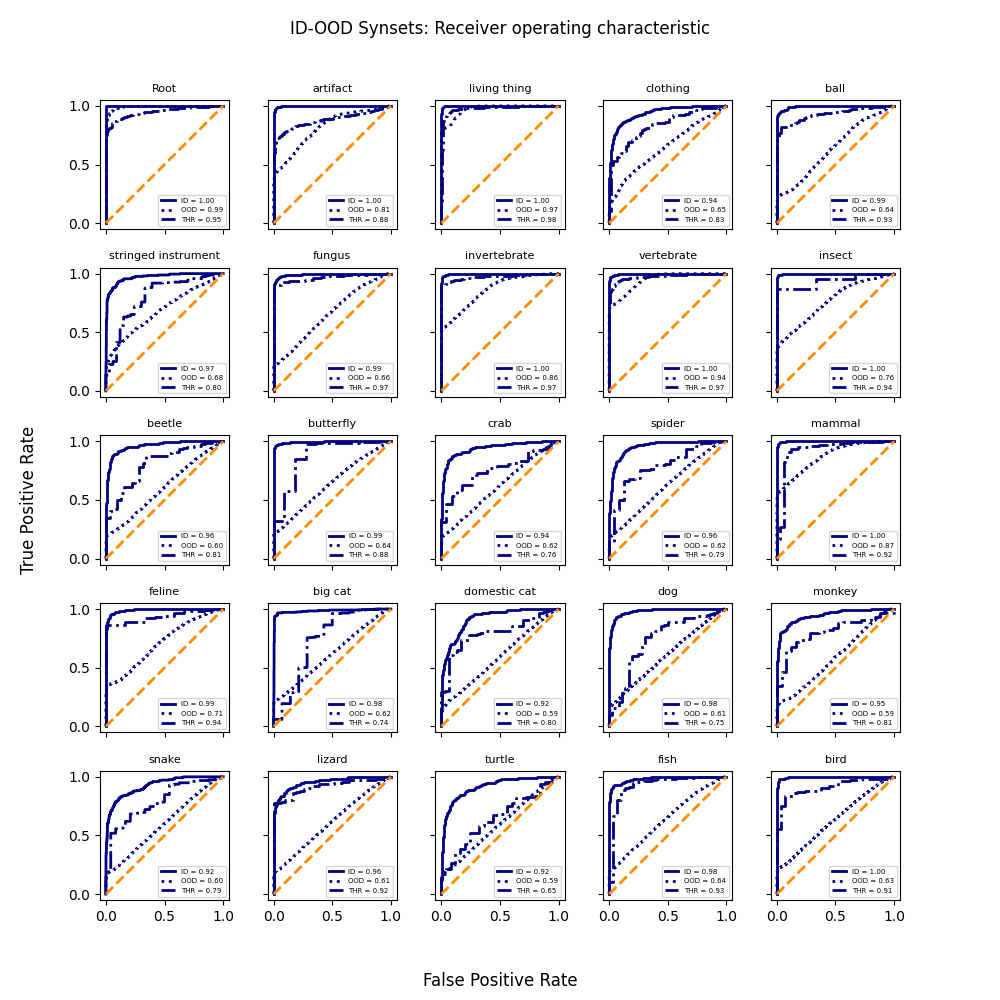

In [274]:
fig, axs = plt.subplots(5,5,sharex='all', sharey='all', figsize=(10,10))
curr_axs = 0
fig.supxlabel('False Positive Rate')
fig.supylabel('True Positive Rate')
fig.suptitle('ID-OOD Synsets: Receiver operating characteristic')
# fig.tight_layout()
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.3)
for i,end_idx in enumerate(id_hierarchy.synset_bounds):
    lw = 2
    ax = axs.ravel()[curr_axs]
    curr_axs += 1
    ax.plot(ID_FPR[i], ID_TPR[i], color='navy', linestyle='-',
         lw=lw, label='ID = %0.2f' % ID_AUC[i])
    ax.plot(IDOOD_FPR[i], IDOOD_TPR[i], color='navy', linestyle=':',
         lw=lw, label='OOD = %0.2f' % IDOOD_AUC[i])
    ax.plot(IDOODTHRESH_FPR[i], IDOODTHRESH_TPR[i], color='navy', linestyle='-.',
         lw=lw, label='THR = %0.2f' % IDOODTHRESH_AUC[i])
    #     ax.plot(o_fpr, o_tpr, color='darkgreen',
    #          lw=lw, label='ODIN = %0.2f' % oroc_auc)
    ax.plot([0, 1], [0, 1], color='darkorange', lw=lw, linestyle='--')
    if id_hierarchy.child2parent[id_hierarchy.class_list[end_idx]] is None:
        synset_name = "Root"
    else:
        synset_name = id_hierarchy.class_description[id_hierarchy.child2parent[id_hierarchy.class_list[end_idx]]]
    ax.set_title(synset_name, fontsize=8)
    ax.legend(loc='lower right', fontsize=5)
plt.show()

<IPython.core.display.Javascript object>


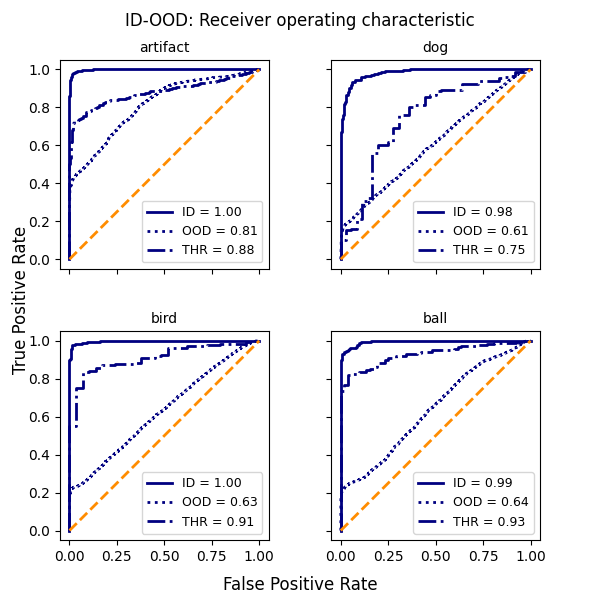

In [276]:
fig, axs = plt.subplots(2,2,sharex='all', sharey='all', figsize=(6,6))
curr_axs = 0
fig.supxlabel('False Positive Rate')
fig.supylabel('True Positive Rate')
fig.suptitle('ID-OOD: Receiver operating characteristic')
# fig.tight_layout()
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.3)
synbounds = id_hierarchy.synset_bounds
syns_ofinterest= [[1, synbounds[1]],[18, synbounds[18]],[24, synbounds[24]],[4, synbounds[4]]]
for i,end_idx in syns_ofinterest:
    lw = 2
    ax = axs.ravel()[curr_axs]
    curr_axs += 1
    ax.plot(ID_FPR[i], ID_TPR[i], color='navy', linestyle='-',
         lw=lw, label='ID = %0.2f' % ID_AUC[i])
    ax.plot(IDOOD_FPR[i], IDOOD_TPR[i], color='navy', linestyle=':',
         lw=lw, label='OOD = %0.2f' % IDOOD_AUC[i])
    ax.plot(IDOODTHRESH_FPR[i], IDOODTHRESH_TPR[i], color='navy', linestyle='-.',
         lw=lw, label='THR = %0.2f' % IDOODTHRESH_AUC[i])
    #     ax.plot(o_fpr, o_tpr, color='darkgreen',
    #          lw=lw, label='ODIN = %0.2f' % oroc_auc)
    ax.plot([0, 1], [0, 1], color='darkorange', lw=lw, linestyle='--')
    if id_hierarchy.child2parent[id_hierarchy.class_list[end_idx]] is None:
        synset_name = "Root"
    else:
        synset_name = id_hierarchy.class_description[id_hierarchy.child2parent[id_hierarchy.class_list[end_idx]]]
    ax.set_title(synset_name, fontsize=10)
    ax.legend(loc='lower right', fontsize=9)
plt.show()

## Gather TNR Thresholds

In [32]:
def get_synset_thresholds(hierarchy, hbscores, hoscores, ml, act, tnr=0.95):
    synset_thresh = []
    for i,end_idx in enumerate(hierarchy.synset_bounds):
        # Gather active synsets
        active_synset_idxs = (act[:,i] == 1)
        synset_gt = (ml[active_synset_idxs])[:,i]
        synset_bsoftpreds = hbscores[i][active_synset_idxs]
        synset_osoftpreds = hoscores[i][active_synset_idxs]
        synset_gtroc = np.zeros((synset_gt.size(0), end_idx-int(hierarchy.synset_offsets[i])+1), dtype=int)
        for j in range(synset_gtroc.shape[1]):
            synset_gtroc[:,j] = (synset_gt[:]==j).cpu().numpy()
#         print(synset_gtroc.shape)
#         print(synset_bsoftpreds.size())
        b_fpr, b_tpr, b_thresh = roc_curve(synset_gtroc.ravel(),
                                           synset_bsoftpreds.cpu().numpy().ravel())
        o_fpr, o_tpr, o_thresh = roc_curve(synset_gtroc.ravel(),
                                           synset_osoftpreds.cpu().numpy().ravel())
        b_idx = np.argmin(np.abs((1-b_fpr)-tnr))
        o_idx = np.argmin(np.abs((1-o_fpr)-tnr))
        btarg = b_thresh[b_idx]
        otarg = o_thresh[o_idx]
        synset_parent = hierarchy.child2parent[hierarchy.class_list[end_idx]]
        synset_desc = hierarchy.class_description[synset_parent] if synset_parent is not None else "ROOT"
        print("{} Synset: btarg {}, otarg {}".format(synset_desc, btarg, otarg))
        synset_thresh.append([btarg, otarg]) 
    return np.array(synset_thresh)

In [34]:
sthresh = get_synset_thresholds(id_hierarchy, train_pred_hbscores, train_pred_hoscores,
                                train_ml, train_act, tnr=.95 )

ROOT Synset: btarg 0.019498053305339862, otarg 0.4990205637525227
artifact Synset: btarg 0.09610400329216837, otarg 0.16710551555195868
living thing Synset: btarg 0.042700840216125587, otarg 0.1673303418625512
clothing Synset: btarg 0.13100896735657835, otarg 0.03378224322359083
ball Synset: btarg 0.08733654482248537, otarg 0.033872405963892696
stringed instrument Synset: btarg 0.15088257938912386, otarg 0.03387737638316494
fungus Synset: btarg 0.10333976025988909, otarg 0.033862349588494725
invertebrate Synset: btarg 0.051491499692527136, otarg 0.056317709643647705
vertebrate Synset: btarg 0.025719523721062752, otarg 0.02824654719242336
insect Synset: btarg 0.07138800508357057, otarg 0.02836366802057583
beetle Synset: btarg 0.13666802181798973, otarg 0.00574183473585539
butterfly Synset: btarg 0.05503676613624345, otarg 0.005739911713023611
crab Synset: btarg 0.15847320001073933, otarg 0.011410869035093505
spider Synset: btarg 0.2845408474753907, otarg 0.011434531069964865
mammal Syns

## Gather TNR Thresh Preds

In [35]:
val_leaf_scores = id_hierarchy.to_leafs(val_pred_hbscores)
_,_,val_soft_preds_hm,_,_,_ = hierarchy_metrics.soft_predict(val_hlogits, id_hierarchy)

In [36]:
def get_thresh_preds(hprobs, synset_thresh, hierarchy):
    # Get soft preds from scores
    # Get soft preds and path through hierarchy
    leaf_scores = hierarchy.to_leafs(hprobs)
    # Max of leaf node scores
    leaf_preds = leaf_scores.max(dim=1)[1]
    # Get multilabel and active_synsets
    pred_ml, pred_act = hierarchy.to_multilabel(leaf_preds)
#     # convert leaf idx to wordnet id
#     leaf_preds = [hierarchy.train_classes[i] for i in leaf_preds]
#     # convert wordnet id to hierarchy class idx
#     leaf_preds = [hierarchy.class_list.index(i) for i in leaf_preds]
    
    # -1 will indicate root
    thresh_preds = np.ones((pred_ml.size(0))) * -1
    thresh_pred_found = np.zeros((pred_ml.size(0)), dtype=bool)
        
    for i,end_idx in enumerate(hierarchy.synset_bounds):
        # Get synset parent
        curr_par = hierarchy.child2parent[hierarchy.class_list[end_idx]]
        # Get active preds
        pred_idxs = (pred_act[:,i] == 1).cpu()
        # Remove already found preds
        pred_idxs = np.logical_and(np.logical_not(thresh_pred_found), pred_idxs).bool()
        # Get predicted probability score for this synset for each example
        curr_probs = hprobs[i].gather(1, pred_ml[:,i].cpu().view(-1,1)).squeeze()
        # Check if threshold is not met
        unconfidxs = (curr_probs < synset_thresh[i]).cpu()
        confidxs = (curr_probs >= synset_thresh[i]).cpu()
        # Combine threshold masks with pred_idxs mask
        unconfidxs = np.logical_and(pred_idxs, unconfidxs).bool()
        confidxs = np.logical_and(pred_idxs, confidxs).bool()
        # Set output for preds that did not meet the confidence threshold
        if curr_par is not None:
            thresh_preds[unconfidxs] = hierarchy.class_list.index(curr_par)
        thresh_pred_found[unconfidxs] = True
        # Update predictions that meet the threshold
        thresh_preds[confidxs] = (pred_ml[:, i][confidxs] + hierarchy.synset_offsets[i]).cpu().numpy()
    return thresh_preds
        
#     if pred_ml.size(0) != ml.size(0):
#         raise ValueError("Number of groundtruth != Number of predictions")

In [37]:
val_tnr95_bpreds = get_thresh_preds(val_pred_hbscores, sthresh[:,0], id_hierarchy)
ood_tnr95_bpreds = get_thresh_preds(ood_pred_hbscores, sthresh[:,0], id_hierarchy)

In [38]:
print(val_tnr95_bpreds.max())
print(val_tnr95_bpreds.min())

print(ood_tnr95_bpreds.max())
print(ood_tnr95_bpreds.min())

print(id_hierarchy.synset_bounds)

106.0
2.0
106.0
2.0
[1, 4, 7, 12, 17, 22, 27, 30, 36, 38, 43, 48, 53, 58, 61, 63, 68, 73, 77, 82, 87, 92, 97, 102, 106]


## Calculate TNR Thresh Accuracy

In [39]:
def get_pred_ml(pred, hierarchy):
    # create list of all nodes in path for each prediction
    pred_path = []
    for i, p in enumerate(pred.astype(int)):
        if p >= 0:
            pred_path.append(copy.deepcopy(hierarchy.class_parents[hierarchy.class_list[p]]))
            pred_path[i].append(p)
        else:
            pred_path.append([])
        
    pred_ml = torch.zeros((pred.shape[0], len(hierarchy.synset_offsets)))
    pred_act = torch.zeros((pred.shape[0], len(hierarchy.synset_offsets)))
    for i, pp in enumerate(pred_path):
        if pp == []:
            continue
        synset_idxs = np.searchsorted(hierarchy.synset_bounds, pp)
        pred_act[i, synset_idxs] = 1 
        pred_ml[i, synset_idxs] = torch.tensor(pp) - hierarchy.synset_offsets[synset_idxs].cpu()
    return pred_ml, pred_act


In [40]:
val_tnr95_bpred_ml, val_tnr95_bpred_act = get_pred_ml(val_tnr95_bpreds, id_hierarchy)
ood_tnr95_bpred_ml, ood_tnr95_bpred_act = get_pred_ml(ood_tnr95_bpreds, id_hierarchy)
# np.searchsorted([0,1],[-1, 0.5,1,1.5])

In [41]:
print(ood_tnr95_bpred_act[0,:])

tensor([1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1.])


In [42]:
def calc_accuracy(pred_ml, pred_act, ml, act, hierarchy):
    ml = ml.clone().detach().cpu()
    act = act.clone().detach().cpu()
    pred_ml = pred_ml.clone().detach().cpu()
    pred_act = pred_act.clone().detach().cpu()
    # Loop over synsets to find accuracy
    error_depth = torch.ones(ml.size(0)) * -1.
    top1_correct = torch.ones(ml.size(0), dtype=torch.bool)

    for i in range(pred_ml.size(1)):
        if (top1_correct.sum() != (error_depth==-1).sum()):
            import ipdb; ipdb.set_trace()
        active_mismatch = torch.logical_xor(act[:,i] == 1, pred_act[:,i] == 1) #XOR: Mismatch
        
        gt_active = torch.where(act[:,i] == 1)
        ml_correct = pred_ml[:,i].eq(ml[:,i])
        active_correct = ml_correct[gt_active]
        active_correct_mask = torch.logical_and(ml_correct, (act[:,i]==1))
        
        # Check that they haven't been in appropriately activated
        top1_correct = torch.logical_and(top1_correct, torch.logical_not(active_mismatch))
        # Check prediction is correct
        top1_correct[gt_active] = torch.logical_and(top1_correct[gt_active], active_correct)
        
        error = torch.logical_or(active_mismatch, torch.logical_not(active_correct_mask))
#         error_depth[active_mismatch] = hierarchy.get_synsetid_depth(i)
        # Check gt active and not correct
        error_occur_at_lvl = torch.logical_and(act[:,i]==1, torch.logical_not(active_correct_mask))
        # Check for pred and gt active mismatch
        error_occur_at_lvl = torch.logical_or(error_occur_at_lvl, active_mismatch)
        # Check error not already found
        error_occur_at_lvl = torch.logical_and(error_occur_at_lvl, error_depth==-1)
        error_depth[error_occur_at_lvl] = hierarchy.get_synsetid_depth(i)
    top1_scores = top1_correct.sum().float().cpu()
    top1_counts = top1_correct.size(0)
    acc = top1_scores/top1_counts
    return acc, error_depth

In [43]:
val_tnr95_bpred_acc, val_tnr95_bpred_errdepths = calc_accuracy(val_tnr95_bpred_ml, val_tnr95_bpred_act, val_ml, val_act, id_hierarchy)
ood_tnr95_bpred_acc, ood_tnr95_bpred_errdepths = calc_accuracy(ood_tnr95_bpred_ml, ood_tnr95_bpred_act, ood_ml, ood_act, id_hierarchy)

In [44]:
print("val tnr95 acc {}".format(val_tnr95_bpred_acc))
print("ood tnr95 acc {}".format(ood_tnr95_bpred_acc))
print(torch.unique(val_tnr95_bpred_errdepths, return_counts=True))
print(torch.unique(ood_tnr95_bpred_errdepths, return_counts=True))

val tnr95 acc 0.8226506114006042
ood tnr95 acc 0.0
(tensor([-1.,  0.,  1.,  2.,  3.,  4.,  5.]), tensor([3414,   27,   72,  183,  257,  121,   76]))
(tensor([0., 1., 2., 3., 4.]), tensor([133, 625,   2,  46,  44]))


In [54]:
torch.cuda.is_available()

True

## Calculate thresholds

In [12]:
from importlib import reload

In [13]:
reload(hierarchy_inference)

<module 'hierarchy_inference' from '/Users/rwl93/duke/CEI/hierarchical-ood/hierarchy_inference.py'>

In [94]:
F.softmax(softmax_logits['train'][0]['logits'], dim=1)[0,:].sum()


tensor(1.0000)

In [14]:
def get_avg_hdist(hdist_mat):
    hdist_total = 0.
    count = 0.
    for i in range(hdist_mat.shape[0]):
        for j in range(hdist_mat.shape[1]):
            hdist_total += (i+j)*hdist_mat[i,j]
            count += hdist_mat[i,j]
    return hdist_total/count
      
def calc_tnr_threshstats(stopcriterion, hierarchy,
                         train_logits, train_targets,
                         val_logits, val_ml, val_act,
                         ood_logits, ood_ml, ood_act,
                         tnr_range=[.9, 1., 1000]):
    val_acc = []
    val_hdist = []
    val_avg_hdist = []
    ood_acc = []
    ood_hdist = []
    ood_avg_hdist = []
    tnr_range = np.linspace(tnr_range[0], tnr_range[1], tnr_range[2])
    for i in range(len(tnr_range)):
        print(f"Iter {i} of {len(tnr_range)}")
        tnr = tnr_range[i]
        sc = stopcriterion(hierarchy, tnr)
        sc.update(train_logits, train_targets, inp_scores=False)
        sc.gen_threshold()
        val_preds = sc.predict(val_logits)
        ood_preds = sc.predict(ood_logits)
        val_hmet = hierarchy_metrics.HierarchicalPredAccuracy(hierarchy, track_hdist=True, is_gt_multilabel=True)
        val_hmet.update_state(torch.tensor(val_preds).long().to(device), (val_ml.to(device), val_act.to(device)))
        ood_hmet = hierarchy_metrics.HierarchicalPredAccuracy(hierarchy, track_hdist=True, is_gt_multilabel=True)
        ood_hmet.update_state(torch.tensor(ood_preds).long().to(device), (ood_ml.to(device), ood_act.to(device)))
        val_acc.append(val_hmet.result())
        vhd = val_hmet.result_hierarchy_distances()
        val_hdist.append(vhd)
        val_avg_hdist.append(get_avg_hdist(vhd))
        ood_acc.append(ood_hmet.result())
        ohd = ood_hmet.result_hierarchy_distances()
        ood_hdist.append(ohd)
        ood_avg_hdist.append(get_avg_hdist(ohd))
    return val_acc, val_hdist, val_avg_hdist, ood_acc, ood_hdist, ood_avg_hdist, tnr_range

In [15]:
FlatSC = hierarchy_inference.FlatStoppingCriterion(id_hierarchy, 0.999)
FlatSC.update(F.softmax(softmax_logits['val'][0]['logits'], dim=1), softmax_logits['val'][0]['targets'])
FlatSC.gen_threshold()
FlatSC.print_threshold()

Threshold: 0.6865636706352234


In [9]:
msp_val_preds = FlatSC.predict(F.softmax(softmax_logits['val'][0]['logits'], dim=1))
msp_ood_preds = FlatSC.predict(F.softmax(softmax_logits['ood'][0]['logits'], dim=1))

In [21]:
ALLtnrmspflat = []
ALLmspflat = []
num_iters = 3
for i in range(num_iters):
    print(f'----------------------   Calculating R{i}   --------------------------')
    msp_train_ml, msp_train_act = id_hierarchy.to_multilabel(softmax_logits['train'][i]["targets"].long())
    msp_val_ml, msp_val_act = id_hierarchy.to_multilabel(softmax_logits['val'][i]["targets"].long())
    msp_full_ood_ml, msp_full_ood_act = ood_hierarchy.to_full_multilabel(softmax_logits['ood'][i]["targets"].long())
    msp_ood_ml, msp_ood_act = id_hierarchy.trim_full_multilabel(msp_full_ood_ml, msp_full_ood_act)

    res_mspflat = calc_tnr_threshstats(
        hierarchy_inference.FlatStoppingCriterion, id_hierarchy,
        softmax_logits['train'][i]['logits'], softmax_logits['train'][i]['targets'],
        softmax_logits['val'][i]['logits'], msp_val_ml, msp_val_act,
        softmax_logits['ood'][i]['logits'], msp_ood_ml, msp_ood_act,
        tnr_range=[0., 1, 100])
    
    ALLtnrmspflat.append(res_mspflat[-1])
    ALLmspflat.append(res_mspflat)

----------------------   Calculating R0   --------------------------
Iter 0 of 100
Iter 1 of 100
Iter 2 of 100
Iter 3 of 100
Iter 4 of 100
Iter 5 of 100
Iter 6 of 100
Iter 7 of 100
Iter 8 of 100
Iter 9 of 100
Iter 10 of 100
Iter 11 of 100
Iter 12 of 100
Iter 13 of 100
Iter 14 of 100
Iter 15 of 100
Iter 16 of 100
Iter 17 of 100
Iter 18 of 100
Iter 19 of 100
Iter 20 of 100
Iter 21 of 100
Iter 22 of 100
Iter 23 of 100
Iter 24 of 100
Iter 25 of 100
Iter 26 of 100
Iter 27 of 100
Iter 28 of 100
Iter 29 of 100
Iter 30 of 100
Iter 31 of 100
Iter 32 of 100
Iter 33 of 100
Iter 34 of 100
Iter 35 of 100
Iter 36 of 100
Iter 37 of 100
Iter 38 of 100
Iter 39 of 100
Iter 40 of 100
Iter 41 of 100
Iter 42 of 100
Iter 43 of 100
Iter 44 of 100
Iter 45 of 100
Iter 46 of 100
Iter 47 of 100
Iter 48 of 100
Iter 49 of 100
Iter 50 of 100
Iter 51 of 100
Iter 52 of 100
Iter 53 of 100
Iter 54 of 100
Iter 55 of 100
Iter 56 of 100
Iter 57 of 100
Iter 58 of 100
Iter 59 of 100
Iter 60 of 100
Iter 61 of 100
Iter 62 of 

In [24]:
ALLtnrodinflat = []
ALLodinflat = []
T=1000.
num_iters = 3
for i in range(num_iters):
    print(f'----------------------   Calculating R{i}   --------------------------')
    odin_train_ml, odin_train_act = id_hierarchy.to_multilabel(softmax_logits['train'][i]["targets"].long())
    odin_val_ml, odin_val_act = id_hierarchy.to_multilabel(softmax_logits['val'][i]["targets"].long())
    odin_full_ood_ml, odin_full_ood_act = ood_hierarchy.to_full_multilabel(softmax_logits['ood'][i]["targets"].long())
    odin_ood_ml, odin_ood_act = id_hierarchy.trim_full_multilabel(odin_full_ood_ml, odin_full_ood_act)

    res_odinflat = calc_tnr_threshstats(
        hierarchy_inference.FlatStoppingCriterion, id_hierarchy,
        softmax_logits['train'][i]['logits']/T, softmax_logits['train'][i]['targets'],
        softmax_logits['val'][i]['logits']/T, odin_val_ml, odin_val_act,
        softmax_logits['ood'][i]['logits']/T, odin_ood_ml, odin_ood_act,
        tnr_range=[0., 1, 100])
    
    ALLtnrodinflat.append(res_odinflat[-1])
    ALLodinflat.append(res_odinflat)

----------------------   Calculating R0   --------------------------
Iter 0 of 100
Iter 1 of 100
Iter 2 of 100
Iter 3 of 100
Iter 4 of 100
Iter 5 of 100
Iter 6 of 100
Iter 7 of 100
Iter 8 of 100
Iter 9 of 100
Iter 10 of 100
Iter 11 of 100
Iter 12 of 100
Iter 13 of 100
Iter 14 of 100
Iter 15 of 100
Iter 16 of 100
Iter 17 of 100
Iter 18 of 100
Iter 19 of 100
Iter 20 of 100
Iter 21 of 100
Iter 22 of 100
Iter 23 of 100
Iter 24 of 100
Iter 25 of 100
Iter 26 of 100
Iter 27 of 100
Iter 28 of 100
Iter 29 of 100
Iter 30 of 100
Iter 31 of 100
Iter 32 of 100
Iter 33 of 100
Iter 34 of 100
Iter 35 of 100
Iter 36 of 100
Iter 37 of 100
Iter 38 of 100
Iter 39 of 100
Iter 40 of 100
Iter 41 of 100
Iter 42 of 100
Iter 43 of 100
Iter 44 of 100
Iter 45 of 100
Iter 46 of 100
Iter 47 of 100
Iter 48 of 100
Iter 49 of 100
Iter 50 of 100
Iter 51 of 100
Iter 52 of 100
Iter 53 of 100
Iter 54 of 100
Iter 55 of 100
Iter 56 of 100
Iter 57 of 100
Iter 58 of 100
Iter 59 of 100
Iter 60 of 100
Iter 61 of 100
Iter 62 of 

In [22]:
msp_id_hdist = np.array([ALLmspflat[0][2],ALLmspflat[1][2],ALLmspflat[2][2]])
msp_ood_hdist = np.array([ALLmspflat[0][5],ALLmspflat[1][5],ALLmspflat[2][5]])

msp_id_hacc = np.array([ALLmspflat[0][0],ALLmspflat[1][0],ALLmspflat[2][0]])
msp_ood_hacc = np.array([ALLmspflat[0][3],ALLmspflat[1][3],ALLmspflat[2][3]])

msp_id_hdist_mean =  msp_id_hdist.mean(0)
msp_ood_hdist_mean = msp_ood_hdist.mean(0)

msp_id_hacc_mean = msp_id_hacc.mean(0)
msp_ood_hacc_mean = msp_ood_hacc.mean(0)

msp_id_hdist_err = msp_id_hdist.std(0)
msp_ood_hdist_err = msp_ood_hdist.std(0)

msp_id_hacc_err = msp_id_hacc.std(0)
msp_ood_hacc_err = msp_ood_hacc.std(0)

In [25]:
odin_id_hdist = np.array([ALLodinflat[0][2],ALLodinflat[1][2],ALLodinflat[2][2]])
odin_ood_hdist = np.array([ALLodinflat[0][5],ALLodinflat[1][5],ALLodinflat[2][5]])

odin_id_hacc = np.array([ALLodinflat[0][0],ALLodinflat[1][0],ALLodinflat[2][0]])
odin_ood_hacc = np.array([ALLodinflat[0][3],ALLodinflat[1][3],ALLodinflat[2][3]])

odin_id_hdist_mean =  odin_id_hdist.mean(0)
odin_ood_hdist_mean = odin_ood_hdist.mean(0)

odin_id_hacc_mean = odin_id_hacc.mean(0)
odin_ood_hacc_mean = odin_ood_hacc.mean(0)

odin_id_hdist_err = odin_id_hdist.std(0)
odin_ood_hdist_err = odin_ood_hdist.std(0)

odin_id_hacc_err = odin_id_hacc.std(0)
odin_ood_hacc_err = odin_ood_hacc.std(0)

<IPython.core.display.Javascript object>


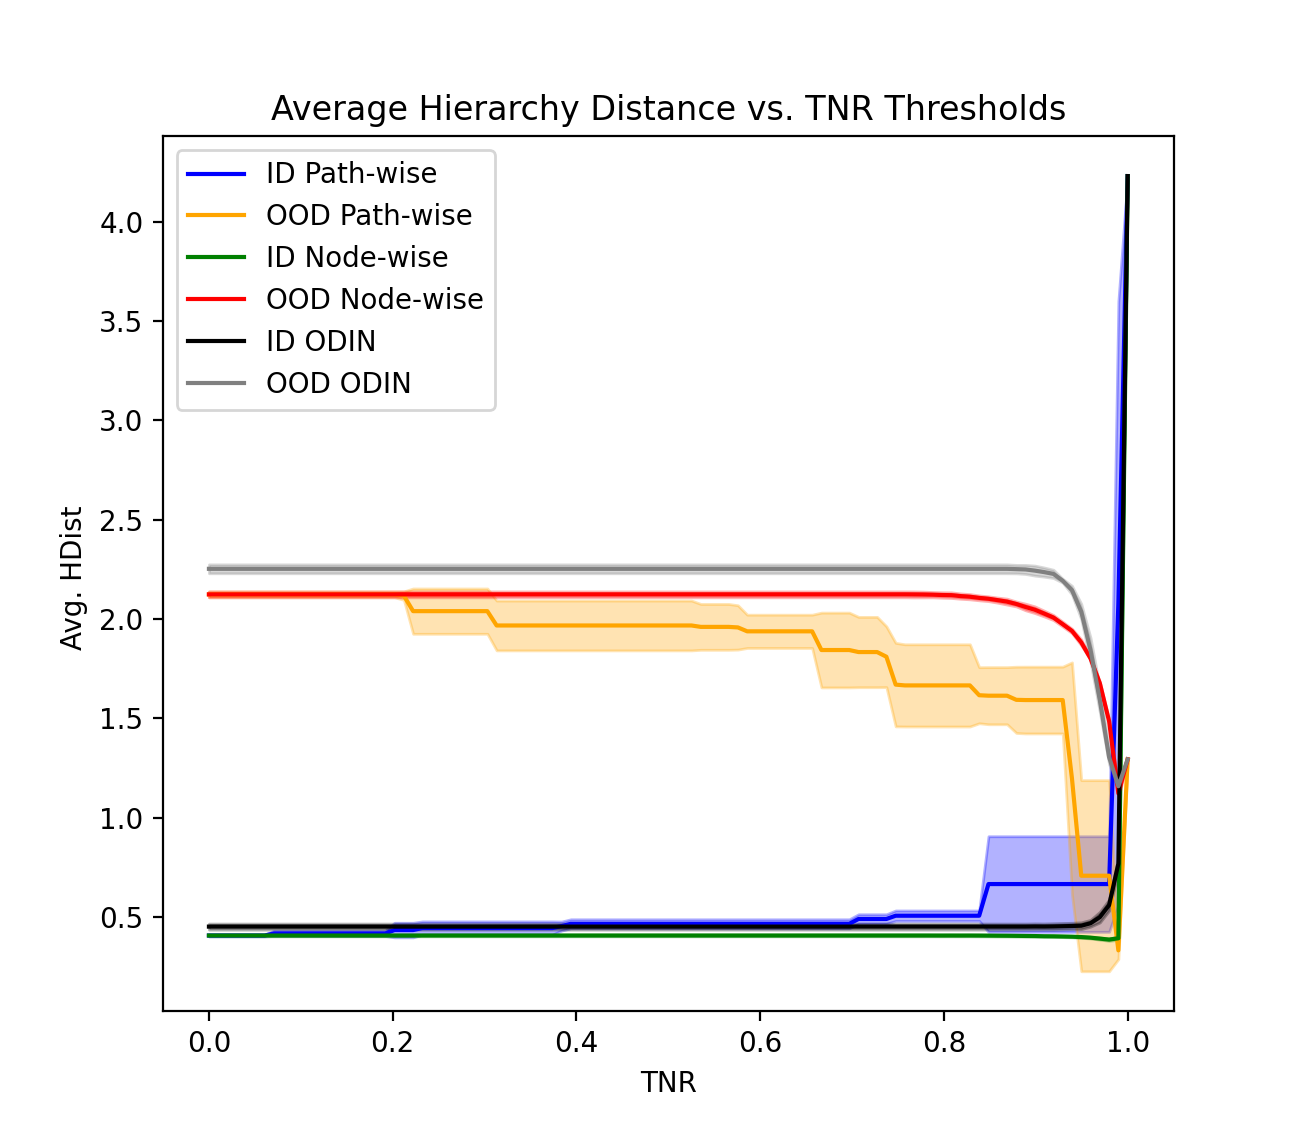

<IPython.core.display.Javascript object>


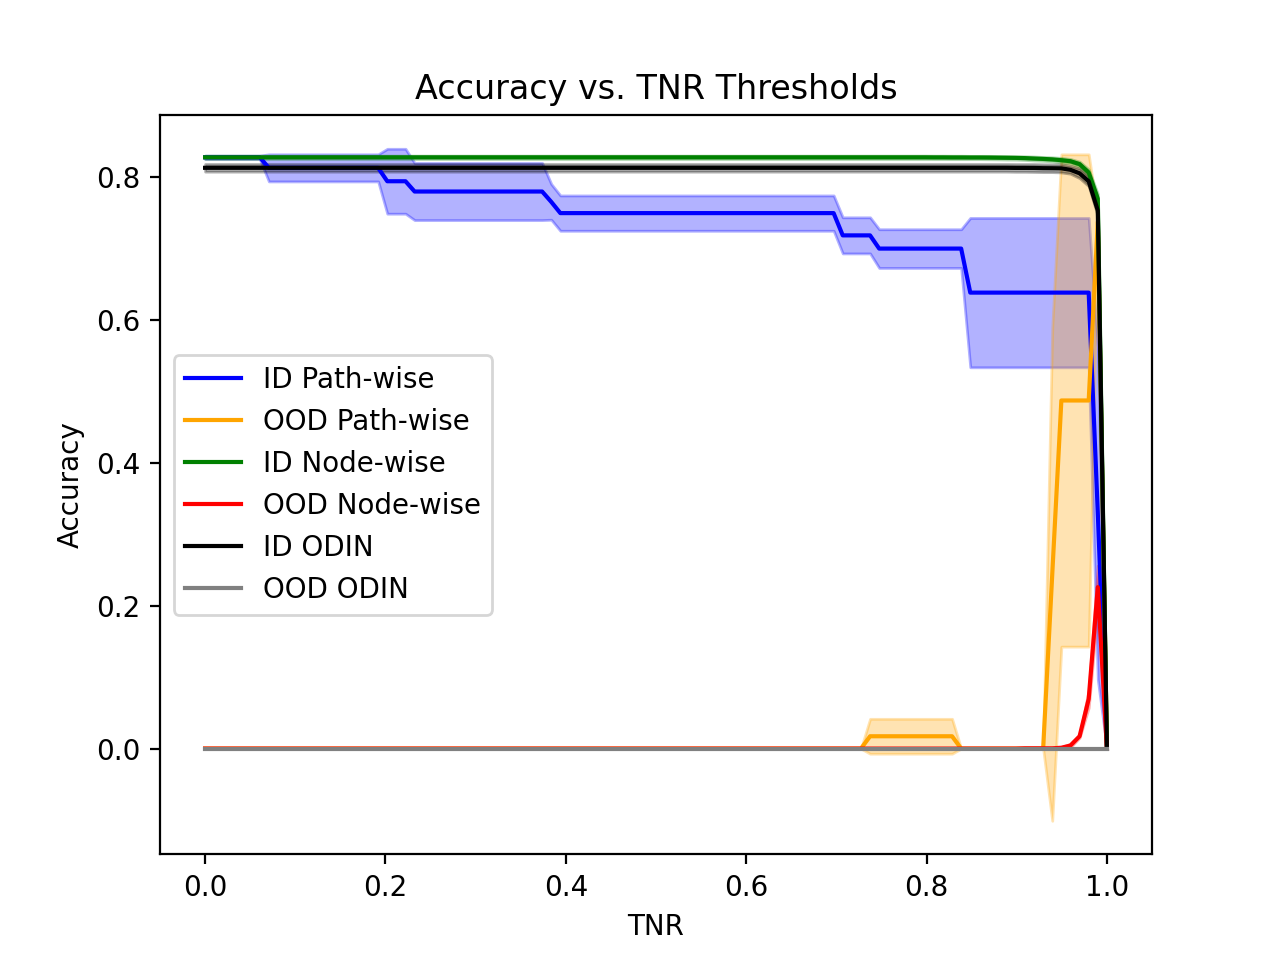

In [76]:
tnrmsp = ALLtnrmspflat[0]
tnrodin = ALLtnrodinflat[0]
tnrsynpp = ressynpred[-1]
tnrppl = res_predpathleaf[-1]

fig = plt.figure()

# Pred path
plt.plot(tnrppl, ppl_id_hdist_mean, 'blue')
plt.plot(tnrppl, ppl_ood_hdist_mean, 'orange')

# Node wise
plt.plot(tnrsynpp, synpp_id_hdist_mean, 'green')
plt.plot(tnrsynpp, synpp_ood_hdist_mean, 'red')

# # MSP
# plt.plot(tnrmsp, msp_id_hdist_mean, 'purple')
# plt.plot(tnrmsp, msp_ood_hdist_mean, 'brown')

# ODIN
plt.plot(tnrodin, odin_id_hdist_mean, 'black')
plt.plot(tnrodin, odin_ood_hdist_mean, 'gray')

# Pred path
plt.fill_between(tnrppl, ppl_id_hdist_mean-ppl_id_hdist_err, ppl_id_hdist_mean+ppl_id_hdist_err, color='blue', alpha=0.3)
plt.fill_between(tnrppl, ppl_ood_hdist_mean-ppl_ood_hdist_err, ppl_ood_hdist_mean+ppl_ood_hdist_err, color='orange', alpha=0.3)

# Node wise
plt.fill_between(tnrsynpp, synpp_id_hdist_mean -synpp_id_hdist_err,  synpp_id_hdist_mean +synpp_id_hdist_err, color='green', alpha=0.3)
plt.fill_between(tnrsynpp, synpp_ood_hdist_mean-synpp_ood_hdist_err, synpp_ood_hdist_mean+synpp_ood_hdist_err, color='red', alpha=0.3)

# # MSP
# plt.fill_between(tnrmsp, msp_id_hdist_mean-msp_id_hdist_err, msp_id_hdist_mean+msp_id_hdist_err, color='purple', alpha=0.3)
# plt.fill_between(tnrmsp, msp_ood_hdist_mean-msp_ood_hdist_err, msp_ood_hdist_mean+msp_ood_hdist_err, color='brown', alpha=0.3)

# ODIN
plt.fill_between(tnrodin, odin_id_hdist_mean-odin_id_hdist_err, odin_id_hdist_mean+odin_id_hdist_err, color='black', alpha=0.3)
plt.fill_between(tnrodin, odin_ood_hdist_mean-odin_ood_hdist_err, odin_ood_hdist_mean+odin_ood_hdist_err, color='gray', alpha=0.3)

plt.ylabel('Avg. HDist ')
plt.xlabel('TNR')
plt.legend(['ID Path-wise', 'OOD Path-wise', 
            'ID Node-wise', 'OOD Node-wise',
#             'ID MSP', 'OOD MSP', 
            'ID ODIN', 'OOD ODIN'])
plt.title('Average Hierarchy Distance vs. TNR Thresholds')
plt.show()

fig = plt.figure()

# Pred path
plt.plot(tnrppl, ppl_id_hacc_mean, 'blue')
plt.plot(tnrppl, ppl_ood_hacc_mean, 'orange')

# Node wise
plt.plot(tnrsynpp, synpp_id_hacc_mean, 'green')
plt.plot(tnrsynpp, synpp_ood_hacc_mean, 'red')

# # MSP
# plt.plot(tnrmsp, msp_id_hacc_mean, 'purple')
# plt.plot(tnrmsp, msp_ood_hacc_mean, 'brown')

# ODIN
plt.plot(tnrodin, odin_id_hacc_mean, 'black')
plt.plot(tnrodin, odin_ood_hacc_mean, 'gray')

# Pred path
plt.fill_between(tnrppl, ppl_id_hacc_mean-ppl_id_hacc_err, ppl_id_hacc_mean+ppl_id_hacc_err, color='blue', alpha=0.3)
plt.fill_between(tnrppl, ppl_ood_hacc_mean-ppl_ood_hacc_err, ppl_ood_hacc_mean+ppl_ood_hacc_err, color='orange', alpha=0.3)

# Node-wise

plt.fill_between(tnrsynpp, synpp_id_hacc_mean -synpp_id_hacc_err,  synpp_id_hacc_mean +synpp_id_hacc_err, color='green', alpha=0.3)
plt.fill_between(tnrsynpp, synpp_ood_hacc_mean-synpp_ood_hacc_err, synpp_ood_hacc_mean+synpp_ood_hacc_err, color='red', alpha=0.3)

# # MSP
# plt.fill_between(tnrmsp, msp_id_hacc_mean-msp_id_hacc_err, msp_id_hacc_mean+msp_id_hacc_err, color='purple', alpha=0.3)
# plt.fill_between(tnrmsp, msp_ood_hacc_mean-msp_ood_hacc_err, msp_ood_hacc_mean+msp_ood_hacc_err, color='brown', alpha=0.3)

# ODIN
plt.fill_between(tnrodin, odin_id_hacc_mean-odin_id_hacc_err, odin_id_hacc_mean+odin_id_hacc_err, color='black', alpha=0.3)
plt.fill_between(tnrodin, odin_ood_hacc_mean-odin_ood_hacc_err, odin_ood_hacc_mean+odin_ood_hacc_err, color='gray', alpha=0.3)

plt.ylabel('Accuracy')
plt.xlabel('TNR')
plt.legend(['ID Path-wise', 'OOD Path-wise',
            'ID Node-wise', 'OOD Node-wise',
#             'ID MSP', 'OOD MSP', 
            'ID ODIN', 'OOD ODIN'])
plt.title('Accuracy vs. TNR Thresholds')
plt.show()

In [12]:
b100_cascade_oe_R0 = torch.load('experiments/balanced100/cascade/pruned-wn/R0_oe/hinference.result')
b100_cascade_oe_R1 = torch.load('experiments/balanced100/cascade/pruned-wn/R1_oe/hinference.result')
b100_cascade_oe_R2 = torch.load('experiments/balanced100/cascade/pruned-wn/R2_oe/hinference.result')
b100_softmax_R0 = torch.load('experiments/balanced100/softmax/R0/hinference.result')
b100_softmax_R1 = torch.load('experiments/balanced100/softmax/R1/hinference.result')
b100_softmax_R2 = torch.load('experiments/balanced100/softmax/R2/hinference.result')

In [27]:
print(b100_cascade_oe_R0['Path Prob 2 SC'].keys())
print(b100_softmax_R0['FlatSC'].keys())

dict_keys(['val_acc', 'val_hdist', 'val_avg_hdist', 'ood_acc', 'ood_hdist', 'ood_avg_hdist', 'tnr_range'])
dict_keys(['val_acc', 'val_hdist', 'val_avg_hdist', 'ood_acc', 'ood_hdist', 'ood_avg_hdist', 'tnr_range'])


In [19]:
np.array([b100_cascade_oe_R0['Path Prob 2 SC']['val_avg_hdist'],
          b100_cascade_oe_R1['Path Prob 2 SC']['val_avg_hdist'],
          b100_cascade_oe_R2['Path Prob 2 SC']['val_avg_hdist'],
         ]).mean(0).shape



(100,)

<IPython.core.display.Javascript object>


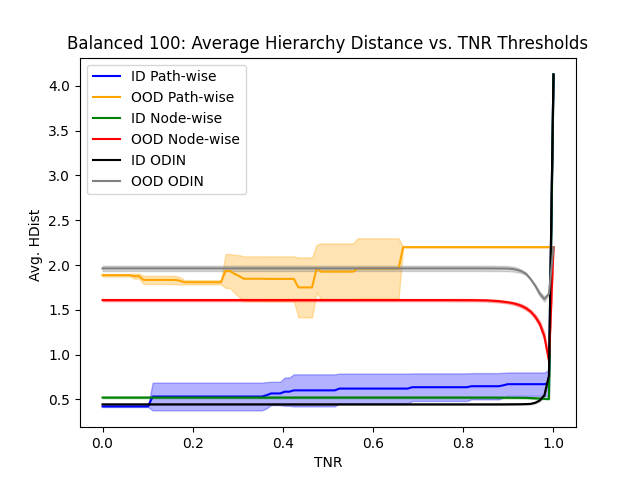

<IPython.core.display.Javascript object>


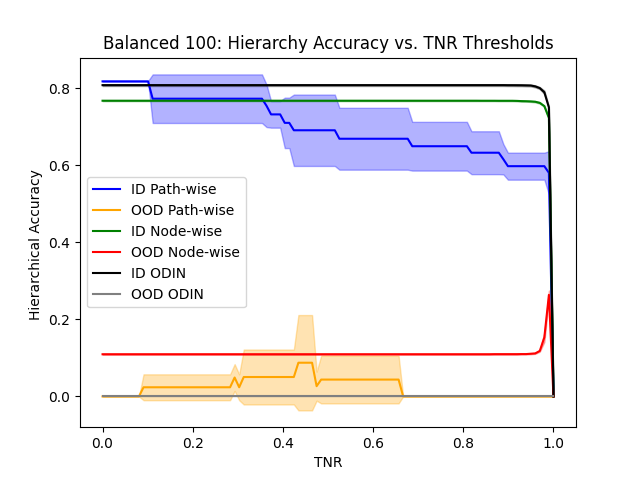

In [36]:
# tnrmsp = ALLtnrmspflat[0]
# tnrodin = ALLtnrodinflat[0]

b100_SPP_valhdist = np.array([b100_cascade_oe_R0['Synset Path Prob SC']['val_avg_hdist'],
                           b100_cascade_oe_R1['Synset Path Prob SC']['val_avg_hdist'],
                           b100_cascade_oe_R2['Synset Path Prob SC']['val_avg_hdist'],
                          ])
b100_PP_valhdist = np.array([b100_cascade_oe_R0['Path Prob 2 SC']['val_avg_hdist'],
                          b100_cascade_oe_R1['Path Prob 2 SC']['val_avg_hdist'],
                          b100_cascade_oe_R2['Path Prob 2 SC']['val_avg_hdist'],
                         ])
b100_SPP_oodhdist = np.array([b100_cascade_oe_R0['Synset Path Prob SC']['ood_avg_hdist'],
                           b100_cascade_oe_R1['Synset Path Prob SC']['ood_avg_hdist'],
                           b100_cascade_oe_R2['Synset Path Prob SC']['ood_avg_hdist'],
                          ])
b100_PP_oodhdist = np.array([b100_cascade_oe_R0['Path Prob 2 SC']['ood_avg_hdist'],
                          b100_cascade_oe_R1['Path Prob 2 SC']['ood_avg_hdist'],
                          b100_cascade_oe_R2['Path Prob 2 SC']['ood_avg_hdist'],
                         ])
b100_MSP_valhdist = np.array([b100_softmax_R0['FlatSC']['val_avg_hdist'],
                              b100_softmax_R1['FlatSC']['val_avg_hdist'],
                              b100_softmax_R2['FlatSC']['val_avg_hdist'],
                             ])
b100_ODIN_valhdist = np.array([b100_softmax_R0['FlatSC ODIN']['val_avg_hdist'],
                               b100_softmax_R1['FlatSC ODIN']['val_avg_hdist'],
                               b100_softmax_R2['FlatSC ODIN']['val_avg_hdist'],
                              ])
b100_MSP_oodhdist = np.array([b100_softmax_R0['FlatSC']['ood_avg_hdist'],
                              b100_softmax_R1['FlatSC']['ood_avg_hdist'],
                              b100_softmax_R2['FlatSC']['ood_avg_hdist'],
                             ])
b100_ODIN_oodhdist = np.array([b100_softmax_R0['FlatSC ODIN']['ood_avg_hdist'],
                               b100_softmax_R1['FlatSC ODIN']['ood_avg_hdist'],
                               b100_softmax_R2['FlatSC ODIN']['ood_avg_hdist'],
                              ])

fig = plt.figure()

# Pred path
plt.plot(b100_cascade_oe_R0['Path Prob 2 SC']['tnr_range'], b100_PP_valhdist.mean(0), 'blue')
plt.plot(b100_cascade_oe_R0['Path Prob 2 SC']['tnr_range'], b100_PP_oodhdist.mean(0), 'orange')

# Node wise
plt.plot(b100_cascade_oe_R0['Synset Path Prob SC']['tnr_range'], b100_SPP_valhdist.mean(0), 'green')
plt.plot(b100_cascade_oe_R0['Synset Path Prob SC']['tnr_range'], b100_SPP_oodhdist.mean(0), 'red')

# MSP
# plt.plot(b100_softmax_R0['FlatSC']['tnr_range'], b100_MSP_valhdist.mean(0), 'purple')
# plt.plot(b100_softmax_R0['FlatSC']['tnr_range'], b100_MSP_oodhdist.mean(0), 'brown')

# ODIN
plt.plot(b100_softmax_R0['FlatSC ODIN']['tnr_range'], b100_ODIN_valhdist.mean(0), 'black')
plt.plot(b100_softmax_R0['FlatSC ODIN']['tnr_range'], b100_ODIN_oodhdist.mean(0), 'gray')

# Pred path
plt.fill_between(b100_cascade_oe_R0['Path Prob 2 SC']['tnr_range'],
                 b100_PP_valhdist.mean(0)-b100_PP_valhdist.std(0),
                 b100_PP_valhdist.mean(0)+b100_PP_valhdist.std(0),
                 color='blue', alpha=0.3)
plt.fill_between(b100_cascade_oe_R0['Path Prob 2 SC']['tnr_range'],
                 b100_PP_oodhdist.mean(0)-b100_PP_oodhdist.std(0),
                 b100_PP_oodhdist.mean(0)+b100_PP_oodhdist.std(0),
                 color='orange', alpha=0.3)

# Node wise
plt.fill_between(b100_cascade_oe_R0['Synset Path Prob SC']['tnr_range'],
                 b100_SPP_valhdist.mean(0)-b100_SPP_valhdist.std(0),
                 b100_SPP_valhdist.mean(0)+b100_SPP_valhdist.std(0),
                 color='green', alpha=0.3)
plt.fill_between(b100_cascade_oe_R0['Synset Path Prob SC']['tnr_range'],
                 b100_SPP_oodhdist.mean(0)-b100_SPP_oodhdist.std(0),
                 b100_SPP_oodhdist.mean(0)+b100_SPP_oodhdist.std(0),
                 color='red', alpha=0.3)

# MSP
# plt.fill_between(b100_softmax_R0['FlatSC']['tnr_range'],
#                  b100_MSP_valhdist.mean(0)-b100_MSP_valhdist.std(0),
#                  b100_MSP_valhdist.mean(0)+b100_MSP_valhdist.std(0),
#                  color='purple', alpha=0.3)
# plt.fill_between(b100_softmax_R0['FlatSC']['tnr_range'],
#                  b100_MSP_oodhdist.mean(0)-b100_MSP_oodhdist.std(0),
#                  b100_MSP_oodhdist.mean(0)+b100_MSP_oodhdist.std(0),
#                  color='brown', alpha=0.3)

# ODIN
plt.fill_between(b100_softmax_R0['FlatSC ODIN']['tnr_range'],
                 b100_ODIN_valhdist.mean(0)-b100_ODIN_valhdist.std(0),
                 b100_ODIN_valhdist.mean(0)+b100_ODIN_valhdist.std(0),
                 color='black', alpha=0.3)
plt.fill_between(b100_softmax_R0['FlatSC ODIN']['tnr_range'],
                 b100_ODIN_oodhdist.mean(0)-b100_ODIN_oodhdist.std(0),
                 b100_ODIN_oodhdist.mean(0)+b100_ODIN_oodhdist.std(0),
                 color='gray', alpha=0.3)

plt.ylabel('Avg. HDist ')
plt.xlabel('TNR')
plt.legend(['ID Path-wise', 'OOD Path-wise', 
            'ID Node-wise', 'OOD Node-wise',
#             'ID MSP', 'OOD MSP', 
            'ID ODIN', 'OOD ODIN'
           ])
plt.title('Balanced 100: Average Hierarchy Distance vs. TNR Thresholds')
plt.show()

b100_SPP_valacc = np.array([b100_cascade_oe_R0['Synset Path Prob SC']['val_acc'],
                           b100_cascade_oe_R1['Synset Path Prob SC']['val_acc'],
                           b100_cascade_oe_R2['Synset Path Prob SC']['val_acc'],
                          ])
b100_PP_valacc = np.array([b100_cascade_oe_R0['Path Prob 2 SC']['val_acc'],
                          b100_cascade_oe_R1['Path Prob 2 SC']['val_acc'],
                          b100_cascade_oe_R2['Path Prob 2 SC']['val_acc'],
                         ])
b100_SPP_oodacc = np.array([b100_cascade_oe_R0['Synset Path Prob SC']['ood_acc'],
                           b100_cascade_oe_R1['Synset Path Prob SC']['ood_acc'],
                           b100_cascade_oe_R2['Synset Path Prob SC']['ood_acc'],
                          ])
b100_PP_oodacc = np.array([b100_cascade_oe_R0['Path Prob 2 SC']['ood_acc'],
                          b100_cascade_oe_R1['Path Prob 2 SC']['ood_acc'],
                          b100_cascade_oe_R2['Path Prob 2 SC']['ood_acc'],
                         ])
b100_MSP_valacc = np.array([b100_softmax_R0['FlatSC']['val_acc'],
                              b100_softmax_R1['FlatSC']['val_acc'],
                              b100_softmax_R2['FlatSC']['val_acc'],
                             ])
b100_ODIN_valacc = np.array([b100_softmax_R0['FlatSC ODIN']['val_acc'],
                               b100_softmax_R1['FlatSC ODIN']['val_acc'],
                               b100_softmax_R2['FlatSC ODIN']['val_acc'],
                              ])
b100_MSP_oodacc = np.array([b100_softmax_R0['FlatSC']['ood_acc'],
                              b100_softmax_R1['FlatSC']['ood_acc'],
                              b100_softmax_R2['FlatSC']['ood_acc'],
                             ])
b100_ODIN_oodacc = np.array([b100_softmax_R0['FlatSC ODIN']['ood_acc'],
                               b100_softmax_R1['FlatSC ODIN']['ood_acc'],
                               b100_softmax_R2['FlatSC ODIN']['ood_acc'],
                              ])

fig = plt.figure()

# Pred path
plt.plot(b100_cascade_oe_R0['Path Prob 2 SC']['tnr_range'], b100_PP_valacc.mean(0), 'blue')
plt.plot(b100_cascade_oe_R0['Path Prob 2 SC']['tnr_range'], b100_PP_oodacc.mean(0), 'orange')

# Node wise
plt.plot(b100_cascade_oe_R0['Synset Path Prob SC']['tnr_range'], b100_SPP_valacc.mean(0), 'green')
plt.plot(b100_cascade_oe_R0['Synset Path Prob SC']['tnr_range'], b100_SPP_oodacc.mean(0), 'red')

# MSP
# plt.plot(b100_softmax_R0['FlatSC']['tnr_range'], b100_MSP_valacc.mean(0), 'purple')
# plt.plot(b100_softmax_R0['FlatSC']['tnr_range'], b100_MSP_oodacc.mean(0), 'brown')

# ODIN
plt.plot(b100_softmax_R0['FlatSC ODIN']['tnr_range'], b100_ODIN_valacc.mean(0), 'black')
plt.plot(b100_softmax_R0['FlatSC ODIN']['tnr_range'], b100_ODIN_oodacc.mean(0), 'gray')

# Pred path
plt.fill_between(b100_cascade_oe_R0['Path Prob 2 SC']['tnr_range'],
                 b100_PP_valacc.mean(0)-b100_PP_valacc.std(0),
                 b100_PP_valacc.mean(0)+b100_PP_valacc.std(0),
                 color='blue', alpha=0.3)
plt.fill_between(b100_cascade_oe_R0['Path Prob 2 SC']['tnr_range'],
                 b100_PP_oodacc.mean(0)-b100_PP_oodacc.std(0),
                 b100_PP_oodacc.mean(0)+b100_PP_oodacc.std(0),
                 color='orange', alpha=0.3)

# Node wise
plt.fill_between(b100_cascade_oe_R0['Synset Path Prob SC']['tnr_range'],
                 b100_SPP_valacc.mean(0)-b100_SPP_valacc.std(0),
                 b100_SPP_valacc.mean(0)+b100_SPP_valacc.std(0),
                 color='green', alpha=0.3)
plt.fill_between(b100_cascade_oe_R0['Synset Path Prob SC']['tnr_range'],
                 b100_SPP_oodacc.mean(0)-b100_SPP_oodacc.std(0),
                 b100_SPP_oodacc.mean(0)+b100_SPP_oodacc.std(0),
                 color='red', alpha=0.3)

# MSP
# plt.fill_between(b100_softmax_R0['FlatSC']['tnr_range'],
#                  b100_MSP_valacc.mean(0)-b100_MSP_valacc.std(0),
#                  b100_MSP_valacc.mean(0)+b100_MSP_valacc.std(0),
#                  color='purple', alpha=0.3)
# plt.fill_between(b100_softmax_R0['FlatSC']['tnr_range'],
#                  b100_MSP_oodacc.mean(0)-b100_MSP_oodacc.std(0),
#                  b100_MSP_oodacc.mean(0)+b100_MSP_oodacc.std(0),
#                  color='brown', alpha=0.3)

# ODIN
plt.fill_between(b100_softmax_R0['FlatSC ODIN']['tnr_range'],
                 b100_ODIN_valacc.mean(0)-b100_ODIN_valacc.std(0),
                 b100_ODIN_valacc.mean(0)+b100_ODIN_valacc.std(0),
                 color='black', alpha=0.3)
plt.fill_between(b100_softmax_R0['FlatSC ODIN']['tnr_range'],
                 b100_ODIN_oodacc.mean(0)-b100_ODIN_oodacc.std(0),
                 b100_ODIN_oodacc.mean(0)+b100_ODIN_oodacc.std(0),
                 color='gray', alpha=0.3)

plt.ylabel('Hierarchical Accuracy ')
plt.xlabel('TNR')
plt.legend(['ID Path-wise', 'OOD Path-wise', 
            'ID Node-wise', 'OOD Node-wise',
#             'ID MSP', 'OOD MSP', 
            'ID ODIN', 'OOD ODIN'
           ])
plt.title('Balanced 100: Hierarchy Accuracy vs. TNR Thresholds')
plt.show()

In [37]:
i1k_cascade_oe_R0 = torch.load('experiments/imagenet1000/imagenet1000-wn-custom/R0_oe_finetune/hinference.result')
i1k_cascade_oe_R1 = torch.load('experiments/imagenet1000/imagenet1000-wn-custom/R1_oe_finetune/hinference.result')
i1k_cascade_oe_R2 = torch.load('experiments/imagenet1000/imagenet1000-wn-custom/R2_oe_finetune/hinference.result')
i1k_softmax_R0 = torch.load('experiments/imagenet1000/softmax/lrp1_R0/hinference.result')
i1k_softmax_R1 = torch.load('experiments/imagenet1000/softmax/lrp1_R1/hinference.result')
i1k_softmax_R2 = torch.load('experiments/imagenet1000/softmax/lrp1_R2/hinference.result')


<IPython.core.display.Javascript object>


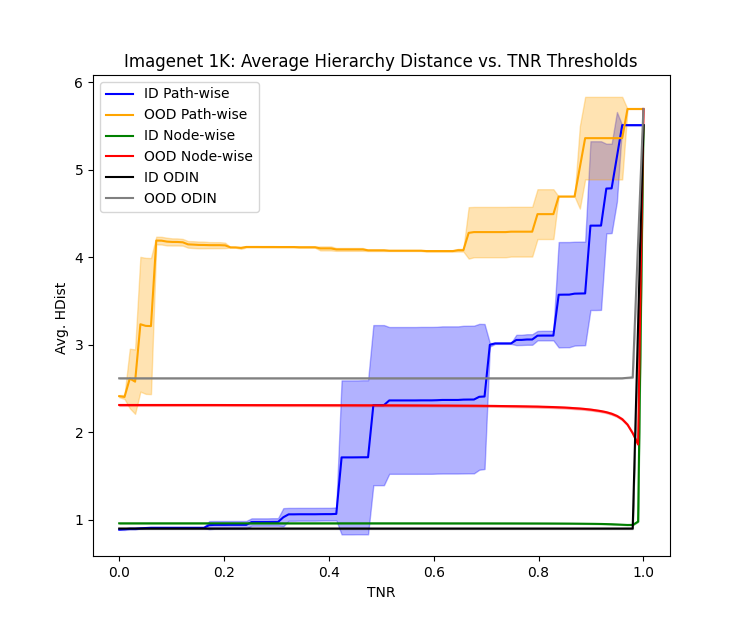

<IPython.core.display.Javascript object>


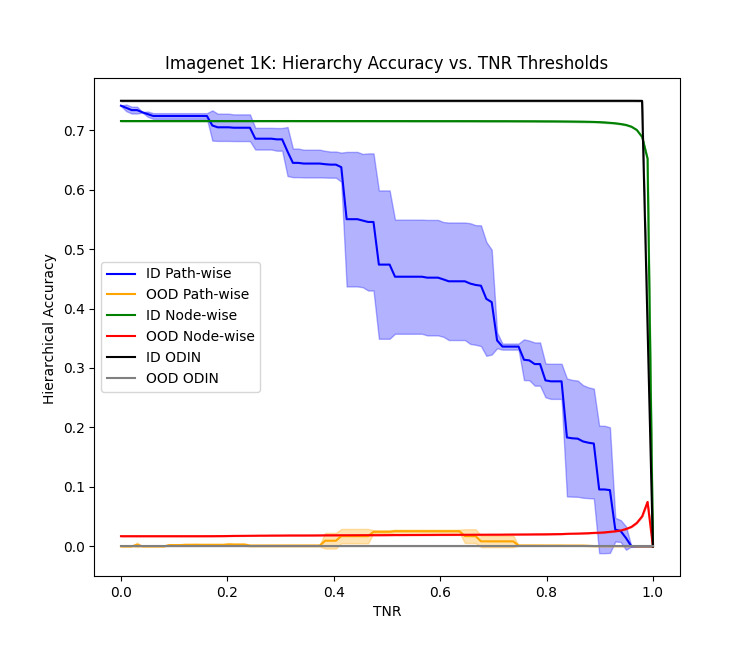

In [39]:
# tnrmsp = ALLtnrmspflat[0]
# tnrodin = ALLtnrodinflat[0]

i1k_SPP_valhdist = np.array([i1k_cascade_oe_R0['Synset Path Prob SC']['val_avg_hdist'],
                           i1k_cascade_oe_R1['Synset Path Prob SC']['val_avg_hdist'],
                           i1k_cascade_oe_R2['Synset Path Prob SC']['val_avg_hdist'],
                          ])
i1k_PP_valhdist = np.array([i1k_cascade_oe_R0['Path Prob 2 SC']['val_avg_hdist'],
                          i1k_cascade_oe_R1['Path Prob 2 SC']['val_avg_hdist'],
                          i1k_cascade_oe_R2['Path Prob 2 SC']['val_avg_hdist'],
                         ])
i1k_SPP_oodhdist = np.array([i1k_cascade_oe_R0['Synset Path Prob SC']['ood_avg_hdist'],
                           i1k_cascade_oe_R1['Synset Path Prob SC']['ood_avg_hdist'],
                           i1k_cascade_oe_R2['Synset Path Prob SC']['ood_avg_hdist'],
                          ])
i1k_PP_oodhdist = np.array([i1k_cascade_oe_R0['Path Prob 2 SC']['ood_avg_hdist'],
                          i1k_cascade_oe_R1['Path Prob 2 SC']['ood_avg_hdist'],
                          i1k_cascade_oe_R2['Path Prob 2 SC']['ood_avg_hdist'],
                         ])
# i1k_MSP_valhdist = np.array([i1k_softmax_R0['FlatSC']['val_avg_hdist'],
#                               i1k_softmax_R1['FlatSC']['val_avg_hdist'],
#                               i1k_softmax_R2['FlatSC']['val_avg_hdist'],
#                              ])
i1k_ODIN_valhdist = np.array([i1k_softmax_R0['FlatSC ODIN']['val_avg_hdist'],
                               i1k_softmax_R1['FlatSC ODIN']['val_avg_hdist'],
                               i1k_softmax_R2['FlatSC ODIN']['val_avg_hdist'],
                              ])
# i1k_MSP_oodhdist = np.array([i1k_softmax_R0['FlatSC']['ood_avg_hdist'],
#                               i1k_softmax_R1['FlatSC']['ood_avg_hdist'],
#                               i1k_softmax_R2['FlatSC']['ood_avg_hdist'],
#                              ])
i1k_ODIN_oodhdist = np.array([i1k_softmax_R0['FlatSC ODIN']['ood_avg_hdist'],
                               i1k_softmax_R1['FlatSC ODIN']['ood_avg_hdist'],
                               i1k_softmax_R2['FlatSC ODIN']['ood_avg_hdist'],
                              ])

fig = plt.figure()

# Pred path
plt.plot(i1k_cascade_oe_R0['Path Prob 2 SC']['tnr_range'], i1k_PP_valhdist.mean(0), 'blue')
plt.plot(i1k_cascade_oe_R0['Path Prob 2 SC']['tnr_range'], i1k_PP_oodhdist.mean(0), 'orange')

# Node wise
plt.plot(i1k_cascade_oe_R0['Synset Path Prob SC']['tnr_range'], i1k_SPP_valhdist.mean(0), 'green')
plt.plot(i1k_cascade_oe_R0['Synset Path Prob SC']['tnr_range'], i1k_SPP_oodhdist.mean(0), 'red')

# MSP
# plt.plot(i1k_softmax_R0['FlatSC']['tnr_range'], i1k_MSP_valhdist.mean(0), 'purple')
# plt.plot(i1k_softmax_R0['FlatSC']['tnr_range'], i1k_MSP_oodhdist.mean(0), 'brown')

# ODIN
plt.plot(i1k_softmax_R0['FlatSC ODIN']['tnr_range'], i1k_ODIN_valhdist.mean(0), 'black')
plt.plot(i1k_softmax_R0['FlatSC ODIN']['tnr_range'], i1k_ODIN_oodhdist.mean(0), 'gray')

# Pred path
plt.fill_between(i1k_cascade_oe_R0['Path Prob 2 SC']['tnr_range'],
                 i1k_PP_valhdist.mean(0)-i1k_PP_valhdist.std(0),
                 i1k_PP_valhdist.mean(0)+i1k_PP_valhdist.std(0),
                 color='blue', alpha=0.3)
plt.fill_between(i1k_cascade_oe_R0['Path Prob 2 SC']['tnr_range'],
                 i1k_PP_oodhdist.mean(0)-i1k_PP_oodhdist.std(0),
                 i1k_PP_oodhdist.mean(0)+i1k_PP_oodhdist.std(0),
                 color='orange', alpha=0.3)

# Node wise
plt.fill_between(i1k_cascade_oe_R0['Synset Path Prob SC']['tnr_range'],
                 i1k_SPP_valhdist.mean(0)-i1k_SPP_valhdist.std(0),
                 i1k_SPP_valhdist.mean(0)+i1k_SPP_valhdist.std(0),
                 color='green', alpha=0.3)
plt.fill_between(i1k_cascade_oe_R0['Synset Path Prob SC']['tnr_range'],
                 i1k_SPP_oodhdist.mean(0)-i1k_SPP_oodhdist.std(0),
                 i1k_SPP_oodhdist.mean(0)+i1k_SPP_oodhdist.std(0),
                 color='red', alpha=0.3)

# MSP
# plt.fill_between(i1k_softmax_R0['FlatSC']['tnr_range'],
#                  i1k_MSP_valhdist.mean(0)-i1k_MSP_valhdist.std(0),
#                  i1k_MSP_valhdist.mean(0)+i1k_MSP_valhdist.std(0),
#                  color='purple', alpha=0.3)
# plt.fill_between(i1k_softmax_R0['FlatSC']['tnr_range'],
#                  i1k_MSP_oodhdist.mean(0)-i1k_MSP_oodhdist.std(0),
#                  i1k_MSP_oodhdist.mean(0)+i1k_MSP_oodhdist.std(0),
#                  color='brown', alpha=0.3)

# ODIN
plt.fill_between(i1k_softmax_R0['FlatSC ODIN']['tnr_range'],
                 i1k_ODIN_valhdist.mean(0)-i1k_ODIN_valhdist.std(0),
                 i1k_ODIN_valhdist.mean(0)+i1k_ODIN_valhdist.std(0),
                 color='black', alpha=0.3)
plt.fill_between(i1k_softmax_R0['FlatSC ODIN']['tnr_range'],
                 i1k_ODIN_oodhdist.mean(0)-i1k_ODIN_oodhdist.std(0),
                 i1k_ODIN_oodhdist.mean(0)+i1k_ODIN_oodhdist.std(0),
                 color='gray', alpha=0.3)

plt.ylabel('Avg. HDist ')
plt.xlabel('TNR')
plt.legend(['ID Path-wise', 'OOD Path-wise', 
            'ID Node-wise', 'OOD Node-wise',
#             'ID MSP', 'OOD MSP', 
            'ID ODIN', 'OOD ODIN'
           ])
plt.title('Imagenet 1K: Average Hierarchy Distance vs. TNR Thresholds')
plt.show()

i1k_SPP_valacc = np.array([i1k_cascade_oe_R0['Synset Path Prob SC']['val_acc'],
                           i1k_cascade_oe_R1['Synset Path Prob SC']['val_acc'],
                           i1k_cascade_oe_R2['Synset Path Prob SC']['val_acc'],
                          ])
i1k_PP_valacc = np.array([i1k_cascade_oe_R0['Path Prob 2 SC']['val_acc'],
                          i1k_cascade_oe_R1['Path Prob 2 SC']['val_acc'],
                          i1k_cascade_oe_R2['Path Prob 2 SC']['val_acc'],
                         ])
i1k_SPP_oodacc = np.array([i1k_cascade_oe_R0['Synset Path Prob SC']['ood_acc'],
                           i1k_cascade_oe_R1['Synset Path Prob SC']['ood_acc'],
                           i1k_cascade_oe_R2['Synset Path Prob SC']['ood_acc'],
                          ])
i1k_PP_oodacc = np.array([i1k_cascade_oe_R0['Path Prob 2 SC']['ood_acc'],
                          i1k_cascade_oe_R1['Path Prob 2 SC']['ood_acc'],
                          i1k_cascade_oe_R2['Path Prob 2 SC']['ood_acc'],
                         ])
# i1k_MSP_valacc = np.array([i1k_softmax_R0['FlatSC']['val_acc'],
#                               i1k_softmax_R1['FlatSC']['val_acc'],
#                               i1k_softmax_R2['FlatSC']['val_acc'],
#                              ])
i1k_ODIN_valacc = np.array([i1k_softmax_R0['FlatSC ODIN']['val_acc'],
                               i1k_softmax_R1['FlatSC ODIN']['val_acc'],
                               i1k_softmax_R2['FlatSC ODIN']['val_acc'],
                              ])
# i1k_MSP_oodacc = np.array([i1k_softmax_R0['FlatSC']['ood_acc'],
#                               i1k_softmax_R1['FlatSC']['ood_acc'],
#                               i1k_softmax_R2['FlatSC']['ood_acc'],
#                              ])
i1k_ODIN_oodacc = np.array([i1k_softmax_R0['FlatSC ODIN']['ood_acc'],
                               i1k_softmax_R1['FlatSC ODIN']['ood_acc'],
                               i1k_softmax_R2['FlatSC ODIN']['ood_acc'],
                              ])

fig = plt.figure()

# Pred path
plt.plot(i1k_cascade_oe_R0['Path Prob 2 SC']['tnr_range'], i1k_PP_valacc.mean(0), 'blue')
plt.plot(i1k_cascade_oe_R0['Path Prob 2 SC']['tnr_range'], i1k_PP_oodacc.mean(0), 'orange')

# Node wise
plt.plot(i1k_cascade_oe_R0['Synset Path Prob SC']['tnr_range'], i1k_SPP_valacc.mean(0), 'green')
plt.plot(i1k_cascade_oe_R0['Synset Path Prob SC']['tnr_range'], i1k_SPP_oodacc.mean(0), 'red')

# MSP
# plt.plot(i1k_softmax_R0['FlatSC']['tnr_range'], i1k_MSP_valacc.mean(0), 'purple')
# plt.plot(i1k_softmax_R0['FlatSC']['tnr_range'], i1k_MSP_oodacc.mean(0), 'brown')

# ODIN
plt.plot(i1k_softmax_R0['FlatSC ODIN']['tnr_range'], i1k_ODIN_valacc.mean(0), 'black')
plt.plot(i1k_softmax_R0['FlatSC ODIN']['tnr_range'], i1k_ODIN_oodacc.mean(0), 'gray')

# Pred path
plt.fill_between(i1k_cascade_oe_R0['Path Prob 2 SC']['tnr_range'],
                 i1k_PP_valacc.mean(0)-i1k_PP_valacc.std(0),
                 i1k_PP_valacc.mean(0)+i1k_PP_valacc.std(0),
                 color='blue', alpha=0.3)
plt.fill_between(i1k_cascade_oe_R0['Path Prob 2 SC']['tnr_range'],
                 i1k_PP_oodacc.mean(0)-i1k_PP_oodacc.std(0),
                 i1k_PP_oodacc.mean(0)+i1k_PP_oodacc.std(0),
                 color='orange', alpha=0.3)

# Node wise
plt.fill_between(i1k_cascade_oe_R0['Synset Path Prob SC']['tnr_range'],
                 i1k_SPP_valacc.mean(0)-i1k_SPP_valacc.std(0),
                 i1k_SPP_valacc.mean(0)+i1k_SPP_valacc.std(0),
                 color='green', alpha=0.3)
plt.fill_between(i1k_cascade_oe_R0['Synset Path Prob SC']['tnr_range'],
                 i1k_SPP_oodacc.mean(0)-i1k_SPP_oodacc.std(0),
                 i1k_SPP_oodacc.mean(0)+i1k_SPP_oodacc.std(0),
                 color='red', alpha=0.3)

# MSP
# plt.fill_between(i1k_softmax_R0['FlatSC']['tnr_range'],
#                  i1k_MSP_valacc.mean(0)-i1k_MSP_valacc.std(0),
#                  i1k_MSP_valacc.mean(0)+i1k_MSP_valacc.std(0),
#                  color='purple', alpha=0.3)
# plt.fill_between(i1k_softmax_R0['FlatSC']['tnr_range'],
#                  i1k_MSP_oodacc.mean(0)-i1k_MSP_oodacc.std(0),
#                  i1k_MSP_oodacc.mean(0)+i1k_MSP_oodacc.std(0),
#                  color='brown', alpha=0.3)

# ODIN
plt.fill_between(i1k_softmax_R0['FlatSC ODIN']['tnr_range'],
                 i1k_ODIN_valacc.mean(0)-i1k_ODIN_valacc.std(0),
                 i1k_ODIN_valacc.mean(0)+i1k_ODIN_valacc.std(0),
                 color='black', alpha=0.3)
plt.fill_between(i1k_softmax_R0['FlatSC ODIN']['tnr_range'],
                 i1k_ODIN_oodacc.mean(0)-i1k_ODIN_oodacc.std(0),
                 i1k_ODIN_oodacc.mean(0)+i1k_ODIN_oodacc.std(0),
                 color='gray', alpha=0.3)

plt.ylabel('Hierarchical Accuracy ')
plt.xlabel('TNR')
plt.legend(['ID Path-wise', 'OOD Path-wise', 
            'ID Node-wise', 'OOD Node-wise',
#             'ID MSP', 'OOD MSP', 
            'ID ODIN', 'OOD ODIN'
           ])
plt.title('Imagenet 1K: Hierarchy Accuracy vs. TNR Thresholds')
plt.show()

In [46]:
SynPPSC = hierarchy_inference.SynsetPathProbStoppingCriterion(id_hierarchy, 0.99)
# SynPPSC.update(val_pred_hbscores,  val_logits['targets'], inp_scores=True)
SynPPSC.update(val_logits['logits'],  val_logits['targets'], inp_scores=False)
SynPPSC.gen_threshold()
# SynPPSC.print_threshold()

SynSoftmaxSC = hierarchy_inference.SynsetSoftmaxStoppingCriterion(id_hierarchy, 0.99)
SynSoftmaxSC.update(val_logits['logits'], val_logits['targets'], inp_scores=False)
SynSoftmaxSC.gen_threshold()
# SynSoftmaxSC.print_threshold()

SynEntSC = hierarchy_inference.SynsetEntropyStoppingCriterion(id_hierarchy, 0.75)
SynEntSC.update(val_logits['logits'], val_logits['targets'], inp_scores=False)
SynEntSC.gen_threshold()

PPSC = hierarchy_inference.PathProbStoppingCriterion(id_hierarchy, 0.9999)
PPSC.update(val_logits['logits'], val_logits['targets'], inp_scores=False)
PPSC.gen_threshold()

PESC = hierarchy_inference.PathEntropyStoppingCriterion(id_hierarchy, 0.9186)
PESC = hierarchy_inference.PathEntropyStoppingCriterion(id_hierarchy, 0.20)
PESC.update(val_logits['logits'], val_logits['targets'], inp_scores=False)
PESC.gen_threshold()

PP2SC = hierarchy_inference.PathProb2StoppingCriterion(id_hierarchy, 0.95)
PP2SC.update(train_logits['logits'], train_logits['targets'], inp_scores=False)
PP2SC.gen_threshold()
# SynEntSC.print_threshold()
# val_hlogits = id_hierarchy.split_logits_by_synset(val_logits['logits'])
# val_logits['targets']

# sthresh = get_synset_thresholds(id_hierarchy, val_pred_hbscores, val_pred_hoscores,
#                                 val_ml, val_act, tnr=.95 )
# val_tnr95_bpreds = get_thresh_preds(val_pred_hbscores, sthresh[:,0], id_hierarchy)
# ood_tnr95_bpreds = get_thresh_preds(ood_pred_hbscores, sthresh[:,0], id_hierarchy)

In [47]:
PP2SC.print_threshold()

Path Probability threshold: 0.8892351388931274


.9185 : -0.11582382023334503  
.9186 : -0.1156565323472023
.91875 : -0.1155332699418068

In [62]:
# SynPPSC.predict(val_logits['logits'])
# val_preds = SynPPSC.predict(val_pred_hbscores, inp_scores=True)
# ood_preds = SynPPSC.predict(ood_pred_hbscores, inp_scores=True)
val_preds = SynPPSC.predict(val_logits['logits'])
ood_preds = SynPPSC.predict(ood_logits['logits'])

# SynPPSC.predict(val_logits['logits'])
val_preds_softmax = SynSoftmaxSC.predict(val_logits['logits'])
ood_preds_softmax = SynSoftmaxSC.predict(ood_logits['logits'])

val_preds_ent = SynEntSC.predict(val_logits['logits'])
ood_preds_ent = SynEntSC.predict(ood_logits['logits'])

val_preds_pp = PPSC.predict(val_logits['logits'])
ood_preds_pp = PPSC.predict(ood_logits['logits'])

val_preds_pe = PESC.predict(val_logits['logits'])
ood_preds_pe = PESC.predict(ood_logits['logits'])

val_preds_pp2 = PP2SC.predict(val_logits['logits'])
ood_preds_pp2 = PP2SC.predict(ood_logits['logits'])

In [63]:
# reload(hierarchy_metrics)
# reload(hierarchy_inference)
# 0.46987951807228917
# 0.5373493975903615

# 0 : 0.404578313253012
# 95: 0.4004819277108434
# 99 : 0.4455421686746988
# 995 : 0.5373493975903615
# tensor(0.7446)
# [[3090    0    0    0    0    0    0]
#  [ 607  318    6    0    0    0    0]
#  [  44   29   17    8    0    0    0]
#  [  11   14    2    0    0    0    0]
#  [   2    1    1    0    0    0    0]
#  [   0    0    0    0    0    0    0]
#  [   0    0    0    0    0    0    0]]
# 0.4004819277108434

In [64]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
HPA = hierarchy_metrics.HierarchicalPredAccuracy(id_hierarchy, track_hdist=True, is_gt_multilabel=True)
HPA.update_state(torch.tensor(val_preds).long().to(device), (val_ml.to(device), val_act.to(device)))
print(HPA.result())
print(HPA.result_hierarchy_distances())
print(get_avg_hdist(HPA.result_hierarchy_distances()))
# HPASoftmax = hierarchy_metrics.HierarchicalPredAccuracy(id_hierarchy, track_hdist=True, is_gt_multilabel=True)
# HPASoftmax.update_state(torch.tensor(val_preds_softmax).long().to(device), (val_ml.to(device), val_act.to(device)))
# print(HPASoftmax.result())
# print(HPASoftmax.result_hierarchy_distances())
# HPAEnt = hierarchy_metrics.HierarchicalPredAccuracy(id_hierarchy, track_hdist=True, is_gt_multilabel=True)
# HPAEnt.update_state(torch.tensor(val_preds_ent).long().to(device), (val_ml.to(device), val_act.to(device)))
# print(HPAEnt.result())
# print(HPAEnt.result_hierarchy_distances())
# HPAPP = hierarchy_metrics.HierarchicalPredAccuracy(id_hierarchy, track_hdist=True, is_gt_multilabel=True)
# HPAPP.update_state(torch.tensor(val_preds_pp).long().to(device), (val_ml.to(device), val_act.to(device)))
# print(HPAPP.result())
# print(HPAPP.result_hierarchy_distances())
# HPAPE = hierarchy_metrics.HierarchicalPredAccuracy(
#     id_hierarchy, track_hdist=True, is_gt_multilabel=True)
# HPAPE.update_state(torch.tensor(val_preds_pe).long().to(
#     device), (val_ml.to(device), val_act.to(device)))
# print(HPAPE.result())
# print(HPAPE.result_hierarchy_distances())
HPAPP2 = hierarchy_metrics.HierarchicalPredAccuracy(
    id_hierarchy, track_hdist=True, is_gt_multilabel=True)
HPAPP2.update_state(torch.tensor(val_preds_pp2).long().to(
    device), (val_ml.to(device), val_act.to(device)))
print(HPAPP2.result())
print(HPAPP2.result_hierarchy_distances())
get_avg_hdist(HPAPP2.result_hierarchy_distances())

No Prediction Found: 5
tensor(0.6713)
[[2786    0    0    0    0    0    0]
 [ 972  171    4    0    0    0    0]
 [ 129   30    9    2    0    0    0]
 [  23   14    1    0    0    0    0]
 [   6    0    0    0    0    0    0]
 [   2    1    0    0    0    0    0]
 [   0    0    0    0    0    0    0]]
0.45542168674698796
tensor(0.6824)
[[2832    0    0    0    0    0    0]
 [ 708  486   21    4    0    0    0]
 [   9   12   27   10    1    1    0]
 [   4    5   24    0    0    0    0]
 [   0    0    4    0    0    0    0]
 [   0    0    2    0    0    0    0]
 [   0    0    0    0    0    0    0]]


0.523855421686747

In [60]:
HPAOOD = hierarchy_metrics.HierarchicalPredAccuracy(id_hierarchy, track_hdist=True, is_gt_multilabel=True)
HPAOOD.update_state(torch.tensor(ood_preds).long().to(device), (ood_ml.to(device), ood_act.to(device)))
print(HPAOOD.result())
print(HPAOOD.result_hierarchy_distances())

# HPASoftmax = hierarchy_metrics.HierarchicalPredAccuracy(id_hierarchy, track_hdist=True, is_gt_multilabel=True)
# HPASoftmax.update_state(torch.tensor(ood_preds_softmax).long().to(device), (ood_ml.to(device), ood_act.to(device)))
# print(HPASoftmax.result())
# print(HPASoftmax.result_hierarchy_distances())

# HPAEntOOD = hierarchy_metrics.HierarchicalPredAccuracy(id_hierarchy, track_hdist=True, is_gt_multilabel=True)
# HPAEntOOD.update_state(torch.tensor(ood_preds_ent).long().to(device), (ood_ml.to(device), ood_act.to(device)))
# print(HPAEntOOD.result())
# print(HPAEntOOD.result_hierarchy_distances())

# HPAPPOOD = hierarchy_metrics.HierarchicalPredAccuracy(id_hierarchy, track_hdist=True, is_gt_multilabel=True)
# HPAPPOOD.update_state(torch.tensor(ood_preds_pp).long().to(device), (ood_ml.to(device), ood_act.to(device)))
# print(HPAPPOOD.result())
# print(HPAPPOOD.result_hierarchy_distances())

# HPAPEOOD = hierarchy_metrics.HierarchicalPredAccuracy(id_hierarchy, track_hdist=True, is_gt_multilabel=True)
# HPAPEOOD.update_state(torch.tensor(ood_preds_pe).long().to(device), (ood_ml.to(device), ood_act.to(device)))
# print(HPAPEOOD.result())
# print(HPAPEOOD.result_hierarchy_distances())

HPAPP2OOD = hierarchy_metrics.HierarchicalPredAccuracy(id_hierarchy, track_hdist=True, is_gt_multilabel=True)
HPAPP2OOD.update_state(torch.tensor(ood_preds_pp2).long().to(
    device), (ood_ml.to(device), ood_act.to(device)))
print(HPAPP2OOD.result())
print(HPAPP2OOD.result_hierarchy_distances())
get_avg_hdist(HPAPP2OOD.result_hierarchy_distances())

tensor(0.4600)
[[399 290 121  28   0   3   0]
 [  2   2   0   0   0   0   0]
 [  1   0   1   0   0   0   0]
 [  2   1   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]]
tensor(0.7294)
[[620 130   0   0   0   0   0]
 [ 50   0   0   0   0   0   0]
 [ 47   0   0   0   0   0   0]
 [  3   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]]


0.33294117647058824

<IPython.core.display.Javascript object>


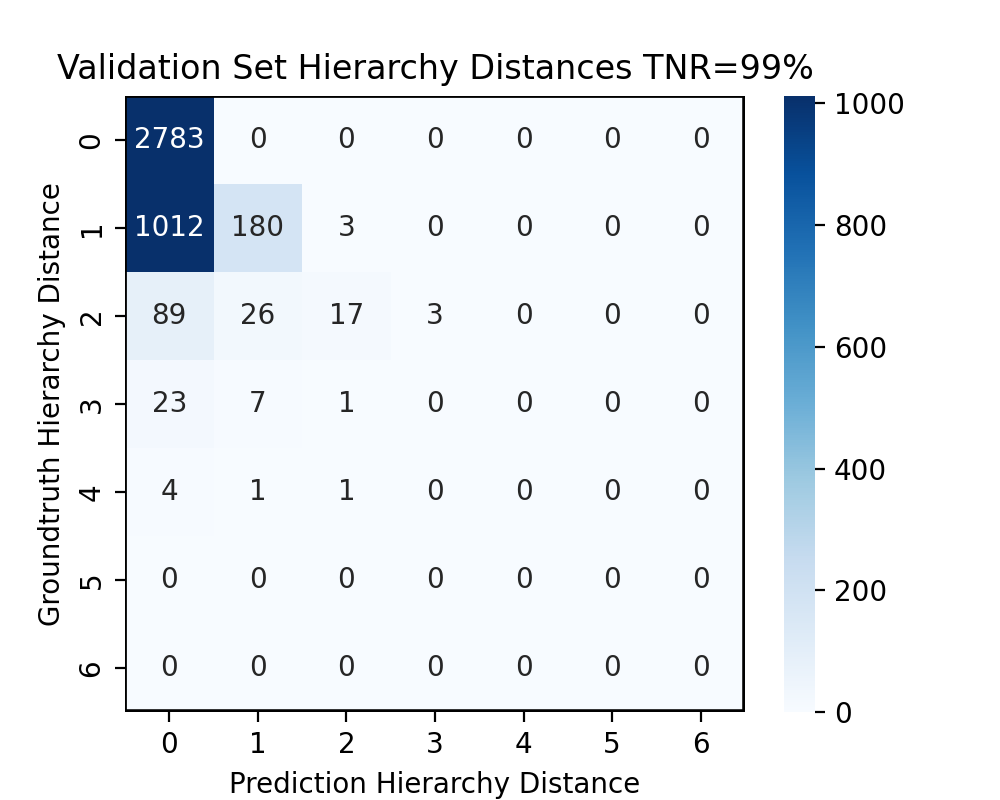

<IPython.core.display.Javascript object>


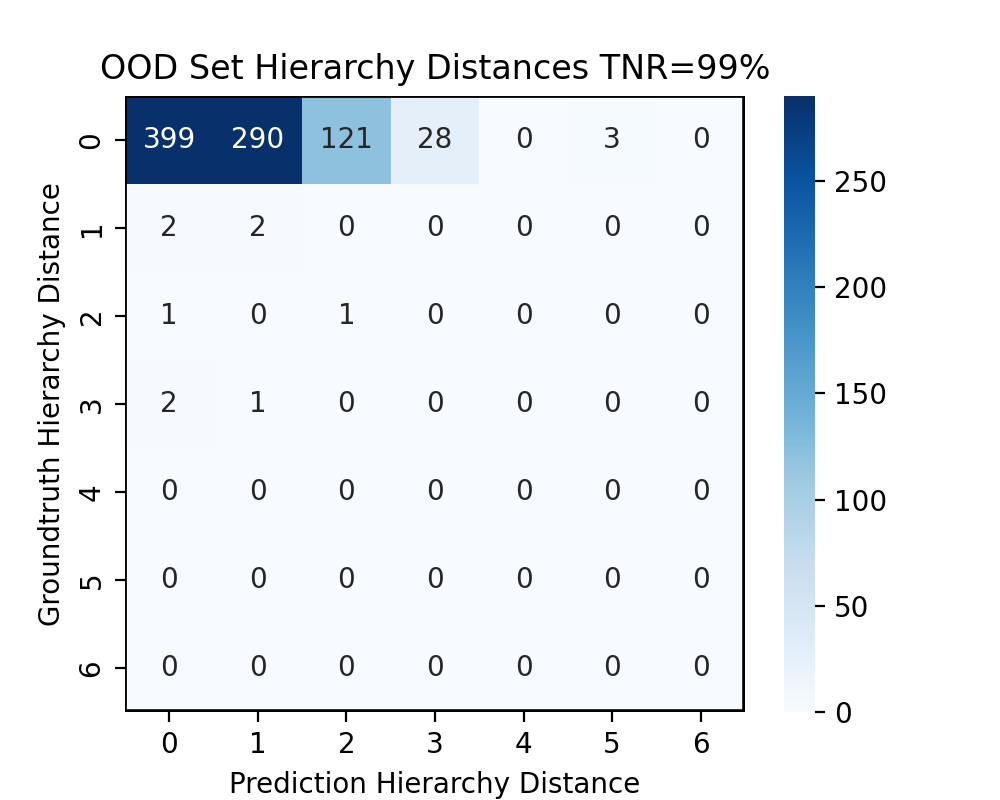

<IPython.core.display.Javascript object>


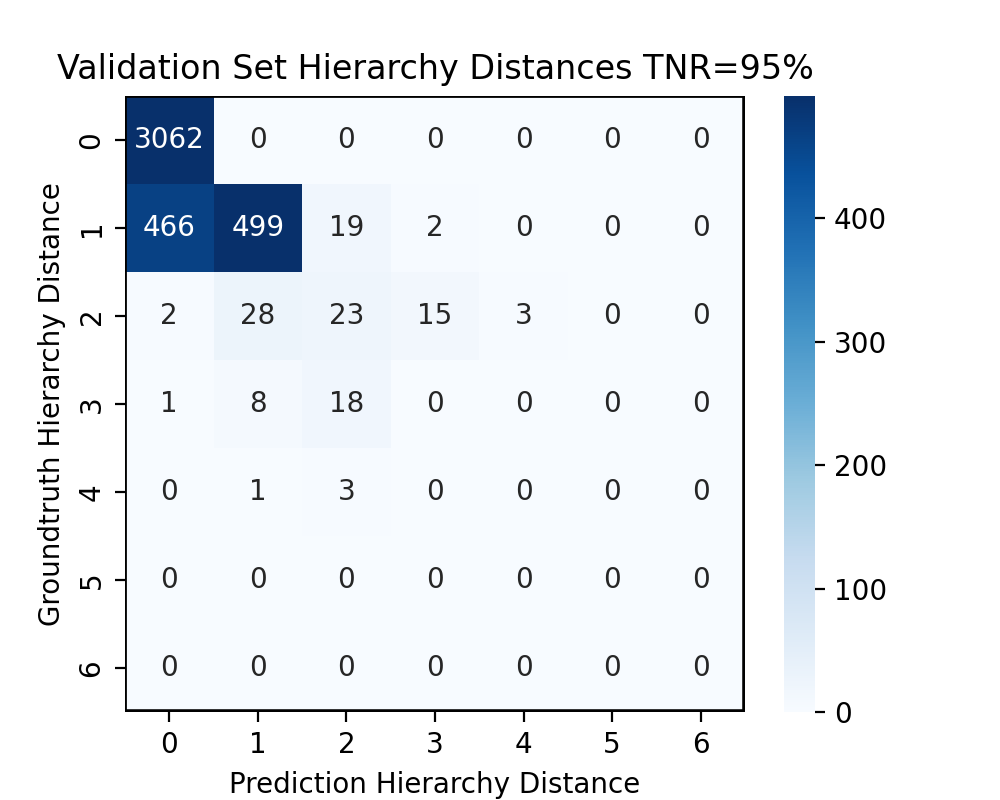

<IPython.core.display.Javascript object>


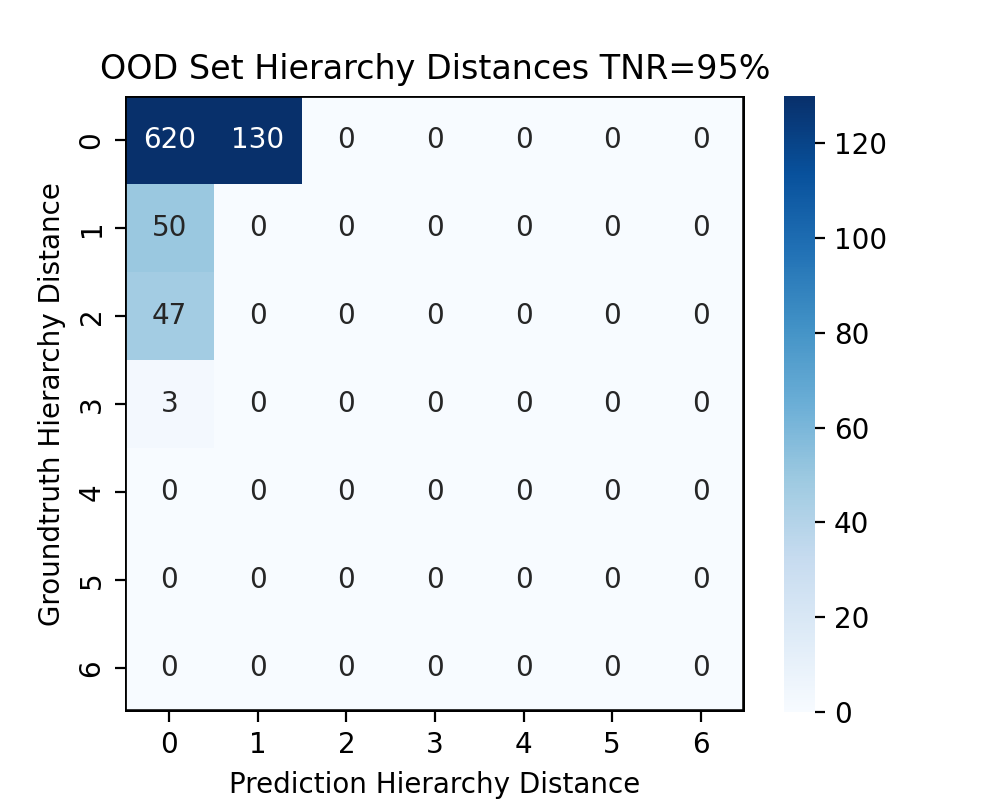

In [61]:
def plot_cmat(cmat, dset='Validation', tnr=0.95, ax=None):
    num_correct = cmat[0,0]
    cmat[0,0] = -1
    vmax = np.max(cmat)
    cmat[0,0] = 10000
    vmin = np.min(cmat)
    cmat[0,0] = num_correct

    cmap_mask = np.ones((*cmat.shape,), dtype=bool)
    cmap_mask[0, 0] = False

    f, ax = plt.subplots(figsize=(5,4))
    ax = sns.heatmap(cmat, annot=True, fmt='d', cmap='Blues', vmin=vmin, vmax=vmax, ax=ax)
    ax.axhline(y=0, color='k',linewidth=1)
    ax.axhline(y=cmat.shape[1], color='k',linewidth=2)
    ax.axvline(x=0, color='k',linewidth=1)
    ax.axvline(x=cmat.shape[0], color='k',linewidth=2)
    # sns.heatmap(val_cmat, annot=True, mask=cmap_mask, cmap=None,)

    plt.ylabel("Groundtruth Hierarchy Distance")
    plt.xlabel("Prediction Hierarchy Distance")
    plt.title(f'{dset} Set Hierarchy Distances TNR={tnr:.0%}')
    
# fig, axs = plt.subplots(2,2,sharex='all', sharey='all')
# curr_axs = 0
# fig.supxlabel('Prediction Hierarchy Distance')
# fig.supylabel('Groundtruth Hierarchy Distance')
# # fig.suptitle('ID Synsets: Receiver operating characteristic')
# # fig.tight_layout()
# # plt.subplots_adjust(left=0.075, bottom=0.05, right=0.95, top=0.9, wspace=0.4, hspace=0.4)

# lw = 2
# ax = axs[0,0]
# ax.plot_cmat(HPA.result_hierarchy_distances(), 'Validation', .99)
# ax.plot(b_fpr, b_tpr, color='darkorange',
#      lw=lw, label='MSP = %0.2f)' % broc_auc)
# #     ax.plot(o_fpr, o_tpr, color='darkgreen',
# #          lw=lw, label='ODIN = %0.2f)' % oroc_auc)
# ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# if id_hierarchy.child2parent[id_hierarchy.class_list[end_idx]] is None:
#     synset_name = "Root"
# else:
#     synset_name = id_hierarchy.class_description[id_hierarchy.child2parent[id_hierarchy.class_list[end_idx]]]
# ax.set_title(synset_name, fontsize=8)
# ax.legend(loc='lower right', fontsize=8)
# plt.show()

# plt.subplot

plot_cmat(HPA.result_hierarchy_distances(), 'Validation', .99)
plot_cmat(HPAOOD.result_hierarchy_distances(), 'OOD', .99)
plot_cmat(HPAPP2.result_hierarchy_distances(), 'Validation', .95)
plot_cmat(HPAPP2OOD.result_hierarchy_distances(), 'OOD', .95)


In [63]:
res_predpathleaf


([tensor(0.8243),
  tensor(0.8243),
  tensor(0.8243),
  tensor(0.8243),
  tensor(0.8243),
  tensor(0.8243),
  tensor(0.8243),
  tensor(0.8243),
  tensor(0.8243),
  tensor(0.8243),
  tensor(0.8243),
  tensor(0.8243),
  tensor(0.8243),
  tensor(0.8243),
  tensor(0.8243),
  tensor(0.8243),
  tensor(0.8243),
  tensor(0.8243),
  tensor(0.8243),
  tensor(0.8243),
  tensor(0.8243),
  tensor(0.8243),
  tensor(0.8243),
  tensor(0.7812),
  tensor(0.7812),
  tensor(0.7812),
  tensor(0.7812),
  tensor(0.7812),
  tensor(0.7812),
  tensor(0.7812),
  tensor(0.7812),
  tensor(0.7812),
  tensor(0.7812),
  tensor(0.7812),
  tensor(0.7812),
  tensor(0.7812),
  tensor(0.7812),
  tensor(0.7812),
  tensor(0.7812),
  tensor(0.7340),
  tensor(0.7340),
  tensor(0.7340),
  tensor(0.7340),
  tensor(0.7340),
  tensor(0.7340),
  tensor(0.7340),
  tensor(0.7340),
  tensor(0.7340),
  tensor(0.7340),
  tensor(0.7340),
  tensor(0.7340),
  tensor(0.7340),
  tensor(0.7340),
  tensor(0.7340),
  tensor(0.7340),
  tensor(0

In [65]:
res_predpathleaf = calc_tnr_threshstats(
    hierarchy_inference.PathProb2StoppingCriterion, id_hierarchy,
    train_logits['logits'], train_logits['targets'],
    val_logits['logits'], val_ml, val_act,
    ood_logits['logits'], ood_ml, ood_act,
    tnr_range=[0., 1, 100])

Iter 0 of 100
Iter 1 of 100
Iter 2 of 100
Iter 3 of 100
Iter 4 of 100
Iter 5 of 100
Iter 6 of 100
Iter 7 of 100
Iter 8 of 100
Iter 9 of 100
Iter 10 of 100
Iter 11 of 100
Iter 12 of 100
Iter 13 of 100
Iter 14 of 100
Iter 15 of 100
Iter 16 of 100
Iter 17 of 100
Iter 18 of 100
Iter 19 of 100
Iter 20 of 100
Iter 21 of 100
Iter 22 of 100
Iter 23 of 100
Iter 24 of 100
Iter 25 of 100
Iter 26 of 100
Iter 27 of 100
Iter 28 of 100
Iter 29 of 100
Iter 30 of 100
Iter 31 of 100
Iter 32 of 100
Iter 33 of 100
Iter 34 of 100
Iter 35 of 100
Iter 36 of 100
Iter 37 of 100
Iter 38 of 100
Iter 39 of 100
Iter 40 of 100
Iter 41 of 100
Iter 42 of 100
Iter 43 of 100
Iter 44 of 100
Iter 45 of 100
Iter 46 of 100
Iter 47 of 100
Iter 48 of 100
Iter 49 of 100
Iter 50 of 100
Iter 51 of 100
Iter 52 of 100
Iter 53 of 100
Iter 54 of 100
Iter 55 of 100
Iter 56 of 100
Iter 57 of 100
Iter 58 of 100
Iter 59 of 100
Iter 60 of 100
Iter 61 of 100
Iter 62 of 100
Iter 63 of 100
Iter 64 of 100
Iter 65 of 100
Iter 66 of 100
Iter 

In [65]:
# res_predpathent = calc_tnr_threshstats(
#     hierarchy_inference.PathEntropyStoppingCriterion, id_hierarchy,
#     train_logits['logits'], train_logits['targets'],
#     val_logits['logits'], val_ml, val_act,
#     ood_logits['logits'], ood_ml, ood_act,
#     tnr_range=[0, 1, 100])
                      

In [66]:
ressynpred = calc_tnr_threshstats(hierarchy_inference.SynsetPathProbStoppingCriterion, id_hierarchy,
                         train_logits['logits'], train_logits['targets'],
                         val_logits['logits'], val_ml, val_act,
                         ood_logits['logits'], ood_ml, ood_act,
                         tnr_range=[.0, 1, 100])
# ressynpred95to1 = calc_tnr_threshstats(hierarchy_inference.SynsetPathProbStoppingCriterion, id_hierarchy,
#                          train_logits['logits'], train_logits['targets'],
#                          val_logits['logits'], val_ml, val_act,
#                          ood_logits['logits'], ood_ml, ood_act,
#                          tnr_range=[.99, 1, 100])

Iter 0 of 100
Iter 1 of 100
Iter 2 of 100
Iter 3 of 100
Iter 4 of 100
Iter 5 of 100
Iter 6 of 100
Iter 7 of 100
Iter 8 of 100
Iter 9 of 100
Iter 10 of 100
Iter 11 of 100
Iter 12 of 100
Iter 13 of 100
Iter 14 of 100
Iter 15 of 100
Iter 16 of 100
Iter 17 of 100
Iter 18 of 100
Iter 19 of 100
Iter 20 of 100
Iter 21 of 100
Iter 22 of 100
Iter 23 of 100
Iter 24 of 100
Iter 25 of 100
Iter 26 of 100
Iter 27 of 100
Iter 28 of 100
Iter 29 of 100
Iter 30 of 100
Iter 31 of 100
Iter 32 of 100
Iter 33 of 100
Iter 34 of 100
Iter 35 of 100
Iter 36 of 100
Iter 37 of 100
Iter 38 of 100
Iter 39 of 100
Iter 40 of 100
Iter 41 of 100
Iter 42 of 100
Iter 43 of 100
Iter 44 of 100
Iter 45 of 100
Iter 46 of 100
Iter 47 of 100
Iter 48 of 100
Iter 49 of 100
Iter 50 of 100
Iter 51 of 100
Iter 52 of 100
Iter 53 of 100
Iter 54 of 100
Iter 55 of 100
Iter 56 of 100
Iter 57 of 100
Iter 58 of 100
Iter 59 of 100
Iter 60 of 100
Iter 61 of 100
Iter 62 of 100
Iter 63 of 100
Iter 64 of 100
Iter 65 of 100
Iter 66 of 100
Iter 

In [67]:
# ressynent = calc_tnr_threshstats(hierarchy_inference.SynsetEntropyStoppingCriterion, id_hierarchy,
#                      train_logits['logits'], train_logits['targets'],
#                      val_logits['logits'], val_ml, val_act,
#                      ood_logits['logits'], ood_ml, ood_act,
#                      tnr_range=[.0, 1, 100])

In [69]:
print(len(ressynpred[-1]))
print(len(res_predpathent[-1]))
print(len(res_predpathleaf[-1]))


100


NameError: name 'res_predpathent' is not defined

In [70]:
print(res_predpathleaf[0])
print(res_predpathleaf[3])
print(res_predpathleaf[-1]
     )

[tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(

<IPython.core.display.Javascript object>


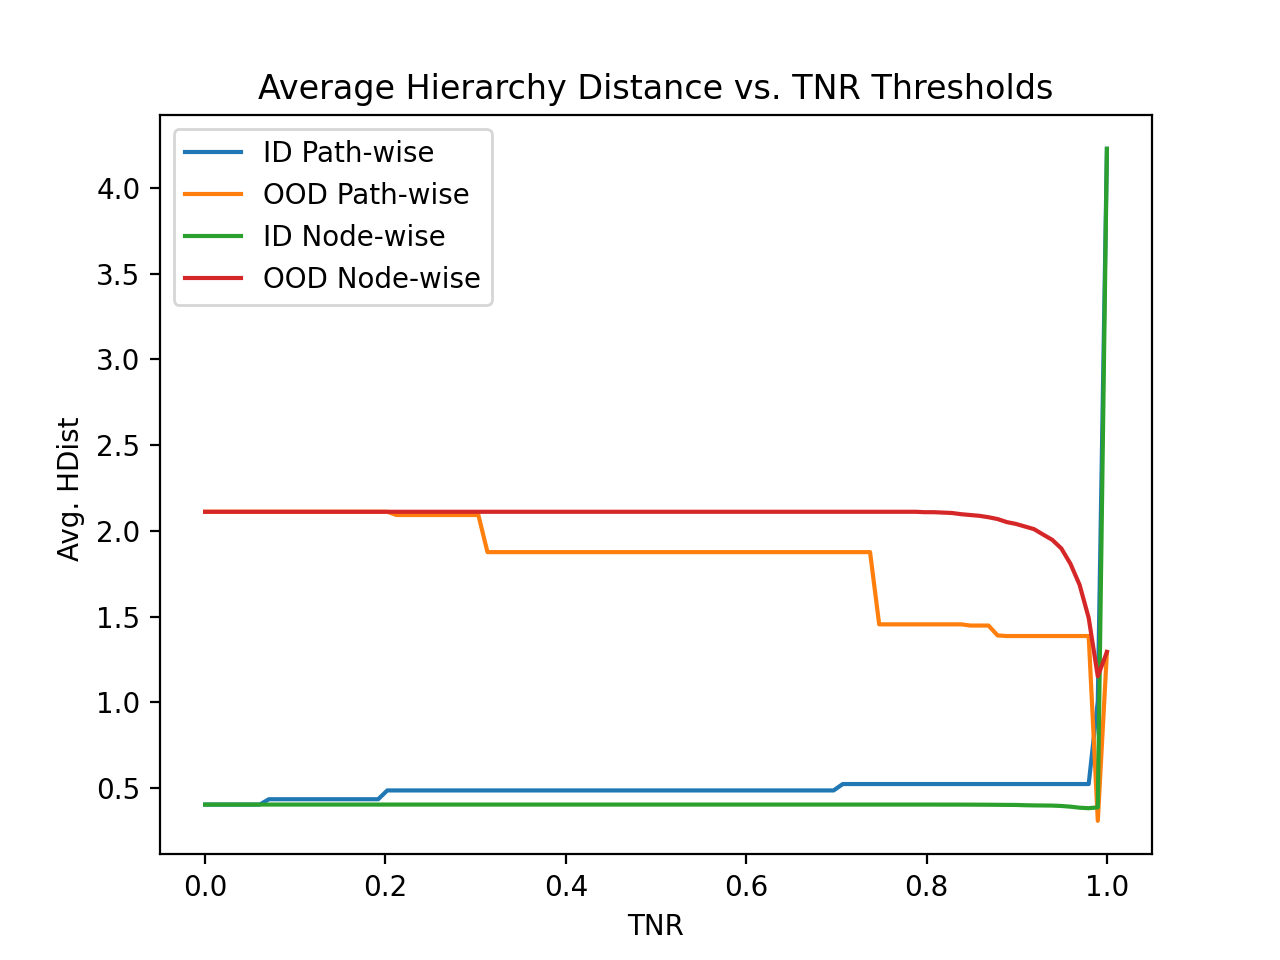

<IPython.core.display.Javascript object>


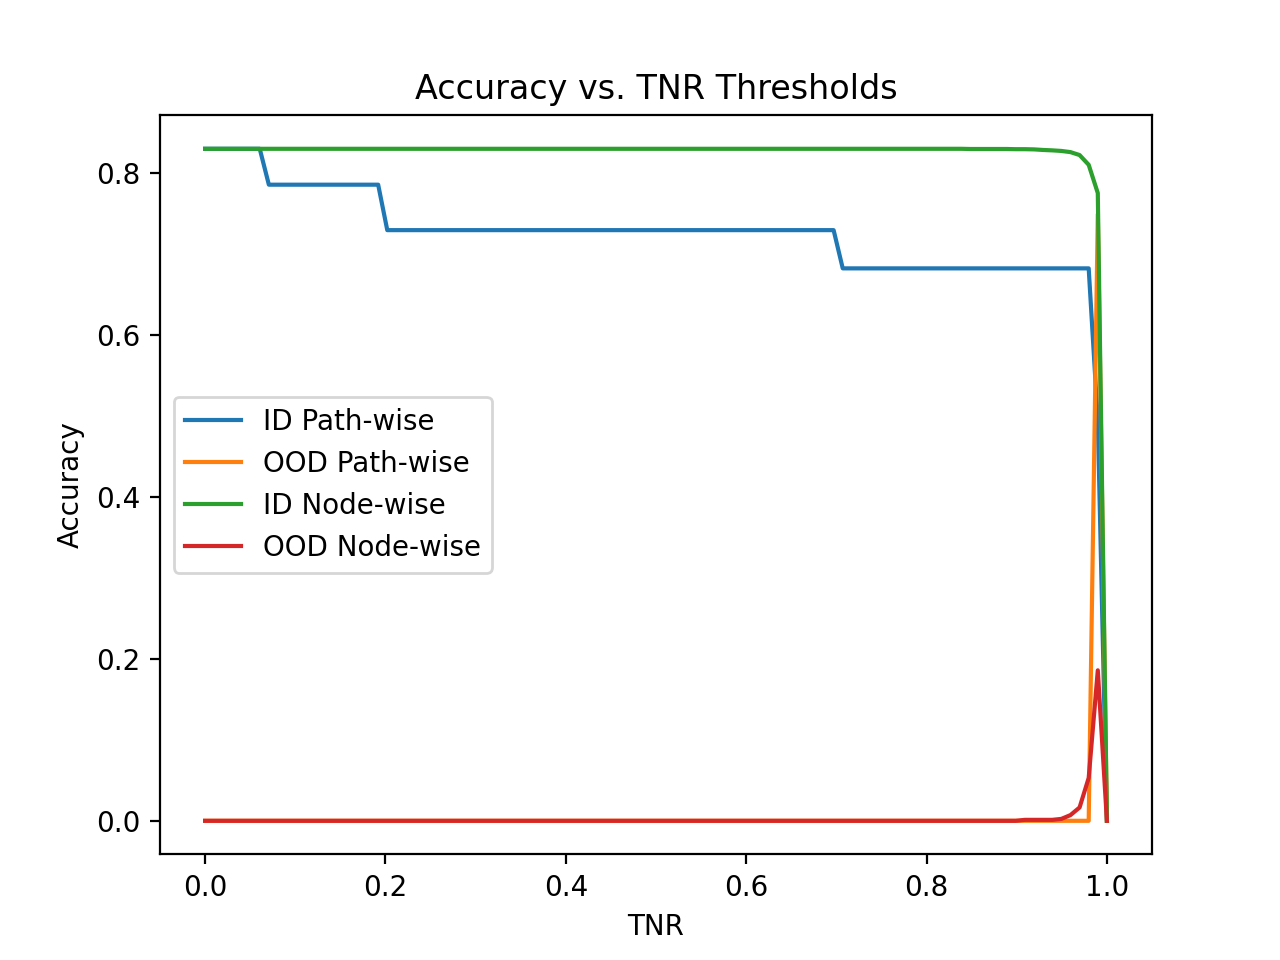

In [67]:
tnrsynpp = ressynpred[-1]
# tnr = res_predpathent[-1]
tnrppl = res_predpathleaf[-1]
# plt.plot(res_predpathent[2][800:990], res_predpathent[5][800:990])
# plt.plot(res_predpathleaf[2], res_predpathleaf[5])
# plt.plot(ressynpred[2], ressynpred[5])
# plt.legend(['Path Entropy', 'Path Probability', 'Synset Prob'])
# plt.ylabel('OOD Avg. HDist ')
# plt.xlabel('ID Avg. HDist ')
# plt.title('Average ID vs. OOD Hierarchy Distance across TNR Thresholds')
# plt.show()

# fig = plt.figure()
# plt.plot(tnr[700:],res_predpathent[2][700:])
# plt.plot(tnrppl[70:], res_predpathleaf[2][70:])
# plt.plot(tnrsynpp[70:], ressynpred[2][70:])
# plt.ylabel('ID Avg. HDist ')
# plt.xlabel('TNR')
# plt.legend(['Path Entropy', 'Path Probability'])
# plt.title('Average ID Hierarchy Distance vs. TNR Thresholds')
# plt.show()

# fig = plt.figure()
# # plt.plot(tnr[700:], res_predpathent[5][700:])
# plt.plot(tnrppl[70:], res_predpathleaf[5][70:])
# plt.plot(tnrsynpp[70:], ressynpred[5][70:])
# # plt.plot(respp1_data[-1], respp1_data[5])
# plt.ylabel('OOD Avg. HDist ')
# # plt.legend(['Path Entropy', 'Path Probability'])
# plt.legend(['Path-wise', 'Node-wise'])
# plt.xlabel('TNR')
# plt.title('Average OOD Hierarchy Distance vs. TNR Thresholds')
# plt.show()

fig = plt.figure()
# plt.plot(tnr, res_predpathent[2], tnr, res_predpathent[5])
plt.plot(tnrppl, res_predpathleaf[2], tnrppl, res_predpathleaf[5])
plt.plot(tnrsynpp, ressynpred[2], tnrsynpp, ressynpred[5])
plt.ylabel('Avg. HDist ')
plt.xlabel('TNR')
plt.legend(['ID Path-wise', 'OOD Path-wise', 'ID Node-wise', 'OOD Node-wise'])
plt.title('Average Hierarchy Distance vs. TNR Thresholds')
plt.show()
         
fig = plt.figure()
# plt.plot(tnr, res_predpathent[0], tnr, res_predpathent[3])
plt.plot(tnrppl, res_predpathleaf[0], tnrppl, res_predpathleaf[3])
plt.plot(tnrsynpp, ressynpred[0], tnrsynpp, ressynpred[3])
# plt.plot(respp1_data[-1], respp1_data[0], respp1_data[-1], respp1_data[3])
plt.ylabel('Accuracy')
plt.xlabel('TNR')
# plt.legend(['ID Path Ent', 'OOD Path Ent', 'ID Path Prob', 'OOD Path Prob'])
plt.legend(['ID Path-wise', 'OOD Path-wise', 'ID Node-wise', 'OOD Node-wise'])
plt.title('Accuracy vs. TNR Thresholds')
plt.show()

In [68]:
if 'ALLtnrppl' not in locals():
    print("Making new lists")
    ALLtnrppl = [tnrppl]
    ALLPPL = [res_predpathleaf]
    ALLtnrsynpp = [tnrsynpp]
    ALLSP = [ressynpred]
else:
    ALLtnrppl.append(tnrppl)
    ALLPPL.append(res_predpathleaf)
    ALLtnrsynpp.append(tnrsynpp)
    ALLSP.append(ressynpred)

In [69]:
print(len(ALLSP))

3


In [70]:
ppl_id_hdist = np.array([ALLPPL[0][2],ALLPPL[1][2],ALLPPL[2][2]])
ppl_ood_hdist = np.array([ALLPPL[0][5],ALLPPL[1][5],ALLPPL[2][5]])
synpp_id_hdist = np.array([ALLSP[0][2],ALLSP[1][2],ALLSP[2][2]])
synpp_ood_hdist = np.array([ALLSP[0][5],ALLSP[1][5],ALLSP[2][5]])

ppl_id_hacc = np.array([ALLPPL[0][0],ALLPPL[1][0],ALLPPL[2][0]])
ppl_ood_hacc = np.array([ALLPPL[0][3],ALLPPL[1][3],ALLPPL[2][3]])
synpp_id_hacc = np.array([ALLSP[0][0],ALLSP[1][0],ALLSP[2][0]])
synpp_ood_hacc = np.array([ALLSP[0][3],ALLSP[1][3],ALLSP[2][3]])


ppl_id_hdist_mean = ppl_id_hdist.mean(0)
ppl_ood_hdist_mean = ppl_ood_hdist.mean(0)
synpp_id_hdist_mean = synpp_id_hdist.mean(0)
synpp_ood_hdist_mean = synpp_ood_hdist.mean(0)

ppl_id_hacc_mean = ppl_id_hacc.mean(0)
ppl_ood_hacc_mean = ppl_ood_hacc.mean(0)
synpp_id_hacc_mean = synpp_id_hacc.mean(0)
synpp_ood_hacc_mean = synpp_ood_hacc.mean(0)

ppl_id_hdist_err = ppl_id_hdist.std(0)
ppl_ood_hdist_err = ppl_ood_hdist.std(0)
synpp_id_hdist_err = synpp_id_hdist.std(0)
synpp_ood_hdist_err = synpp_ood_hdist.std(0)

ppl_id_hacc_err = ppl_id_hacc.std(0)
ppl_ood_hacc_err = ppl_ood_hacc.std(0)
synpp_id_hacc_err = synpp_id_hacc.std(0)
synpp_ood_hacc_err = synpp_ood_hacc.std(0)

<IPython.core.display.Javascript object>


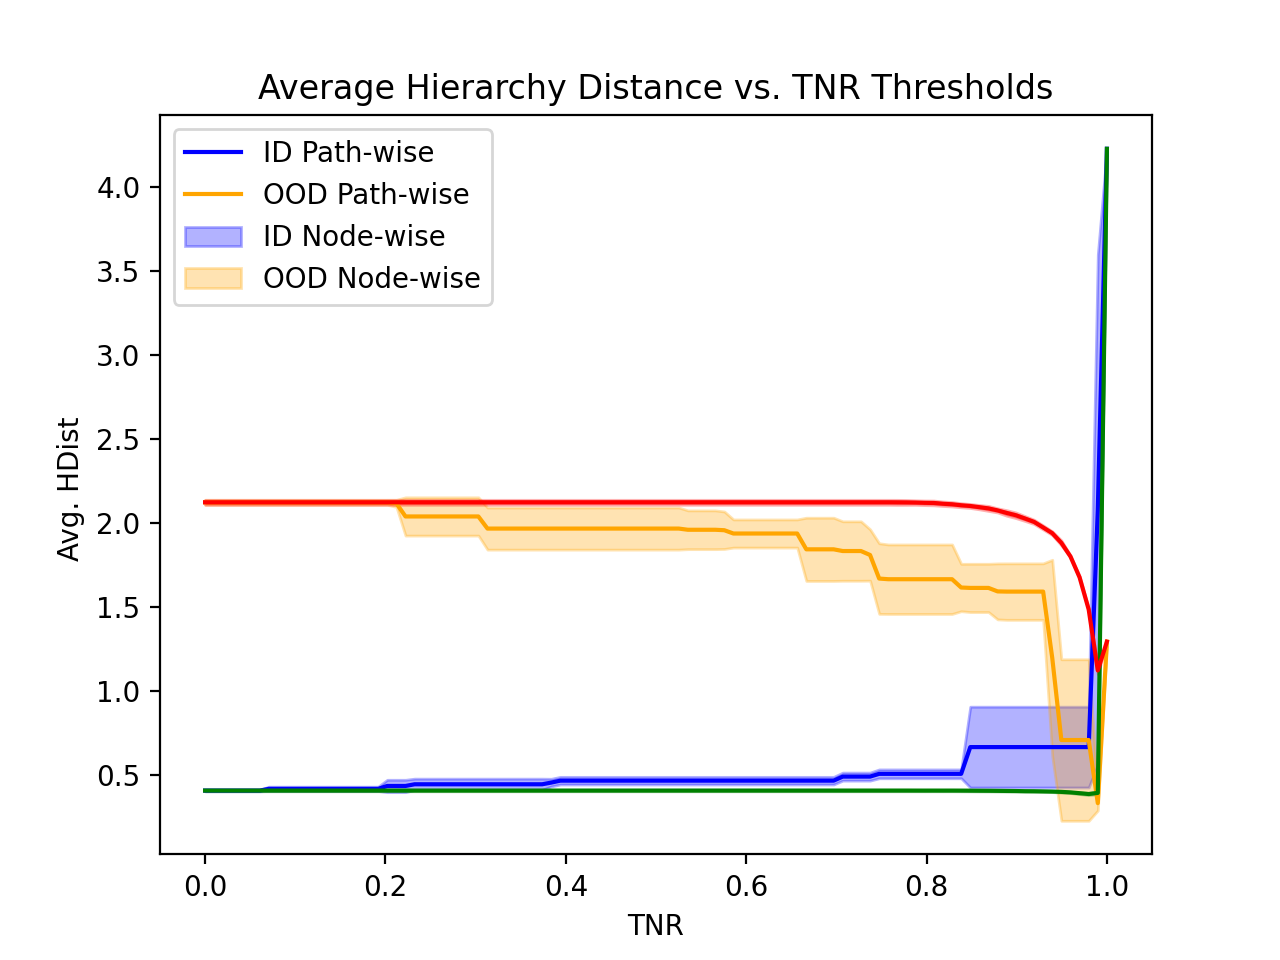

<IPython.core.display.Javascript object>


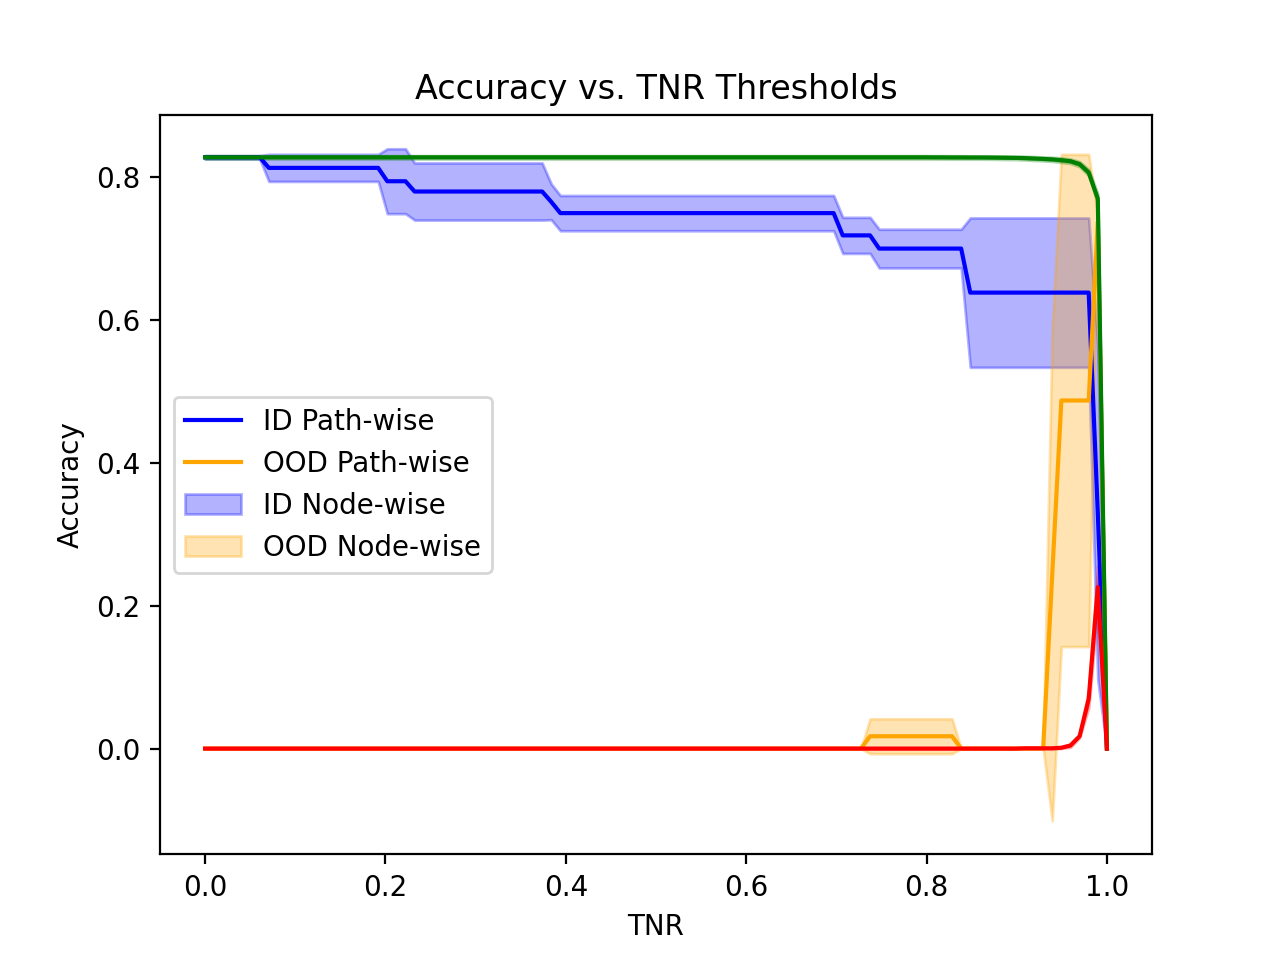

In [71]:
tnrsynpp = ressynpred[-1]
tnrppl = res_predpathleaf[-1]
fig = plt.figure()
# plt.plot(tnr, res_predpathent[2], tnr, res_predpathent[5])
plt.plot(tnrppl, ppl_id_hdist_mean, 'blue')
plt.plot(tnrppl, ppl_ood_hdist_mean, 'orange')
plt.fill_between(tnrppl, ppl_id_hdist_mean-ppl_id_hdist_err, ppl_id_hdist_mean+ppl_id_hdist_err, color='blue', alpha=0.3)
plt.fill_between(tnrppl, ppl_ood_hdist_mean-ppl_ood_hdist_err, ppl_ood_hdist_mean+ppl_ood_hdist_err, color='orange', alpha=0.3)
plt.plot(tnrsynpp, synpp_id_hdist_mean, 'green')
plt.plot(tnrsynpp, synpp_ood_hdist_mean, 'red')
plt.fill_between(tnrsynpp, synpp_id_hdist_mean -synpp_id_hdist_err,  synpp_id_hdist_mean +synpp_id_hdist_err, color='green', alpha=0.3)
plt.fill_between(tnrsynpp, synpp_ood_hdist_mean-synpp_ood_hdist_err, synpp_ood_hdist_mean+synpp_ood_hdist_err, color='red', alpha=0.3)
plt.ylabel('Avg. HDist ')
plt.xlabel('TNR')
plt.legend(['ID Path-wise', 'OOD Path-wise', 'ID Node-wise', 'OOD Node-wise'])
plt.title('Average Hierarchy Distance vs. TNR Thresholds')
plt.show()

fig = plt.figure()
# plt.plot(tnr, res_predpathent[2], tnr, res_predpathent[5])
plt.plot(tnrppl, ppl_id_hacc_mean, 'blue')
plt.plot(tnrppl, ppl_ood_hacc_mean, 'orange')
plt.fill_between(tnrppl, ppl_id_hacc_mean-ppl_id_hacc_err, ppl_id_hacc_mean+ppl_id_hacc_err, color='blue', alpha=0.3)
plt.fill_between(tnrppl, ppl_ood_hacc_mean-ppl_ood_hacc_err, ppl_ood_hacc_mean+ppl_ood_hacc_err, color='orange', alpha=0.3)
plt.plot(tnrsynpp, synpp_id_hacc_mean, 'green')
plt.plot(tnrsynpp, synpp_ood_hacc_mean, 'red')
plt.fill_between(tnrsynpp, synpp_id_hacc_mean -synpp_id_hacc_err,  synpp_id_hacc_mean +synpp_id_hacc_err, color='green', alpha=0.3)
plt.fill_between(tnrsynpp, synpp_ood_hacc_mean-synpp_ood_hacc_err, synpp_ood_hacc_mean+synpp_ood_hacc_err, color='red', alpha=0.3)
plt.ylabel('Accuracy')
plt.xlabel('TNR')
plt.legend(['ID Path-wise', 'OOD Path-wise', 'ID Node-wise', 'OOD Node-wise'])
plt.title('Accuracy vs. TNR Thresholds')
plt.show()



In [54]:
res_predpathleaf=None
tnrppl = None
tnrsynpp = None
ressynpred = None
print(ALLPPL)
print(ALLSP)

[([tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.8275), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tensor(0.7841), tenso

In [ ]:
fig = plt.figure()
tnr = ressynpred[-1]
tnrent = ressynent[-1]
tnrpp1 = respp1[-1]
# plt.plot(ressynpred[2], ressynpred[5])
# plt.plot(ressynent[2], ressynent[5])
plt.plot(respp1[2], respp1[5])
plt.ylabel('OOD Avg. HDist ')
plt.xlabel('ID Avg. HDist ')
plt.title('Average ID vs. OOD Hierarchy Distance across TNR Thresholds')
plt.show()

fig = plt.figure()
# plt.plot(tnr,ressynpred[2])
# plt.plot(tnrent,ressynent[2])
plt.plot(tnrpp1,respp1[2])
plt.ylabel('ID Avg. HDist ')
plt.xlabel('TNR')
plt.title('Average ID Hierarchy Distance vs. TNR Thresholds')
plt.show()
fig = plt.figure()
# plt.plot(tnr, ressynpred[5])
plt.plot(tnrpp1, respp1[5])
plt.ylabel('OOD Avg. HDist ')
plt.xlabel('TNR')
plt.title('Average OOD Hierarchy Distance vs. TNR Thresholds')
plt.show()

fig = plt.figure()
# plt.plot(tnr, ressynpred[2], tnr, ressynpred[5])
# plt.plot(tnrent, ressynent[2], tnrent, ressynent[5])
plt.plot(tnrpp1, respp1[2], tnrpp1, respp1[5])
plt.ylabel('Avg. HDist ')
plt.xlabel('TNR')
plt.legend(['ID', 'OOD'])
plt.title('Average Hierarchy Distance vs. TNR Thresholds')
plt.show()
         
fig = plt.figure()
# plt.plot(tnr, ressynpred[0], tnr, ressynpred[3])
# plt.plot(tnrent, ressynent[0], tnrent, ressynent[3])
plt.plot(tnrpp1, respp1[0], tnrpp1, respp1[3])
plt.ylabel('Accuracy')
plt.xlabel('TNR')
plt.legend(['ID', 'OOD'])
plt.title('Average Hierarchy Distance vs. TNR Thresholds')
plt.show()

<IPython.core.display.Javascript object>


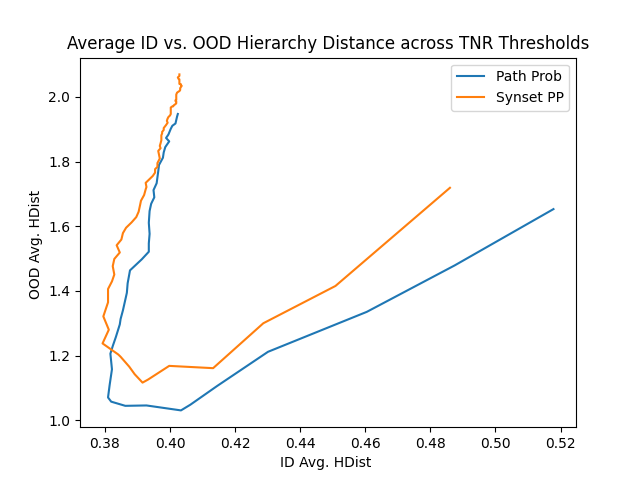

<IPython.core.display.Javascript object>


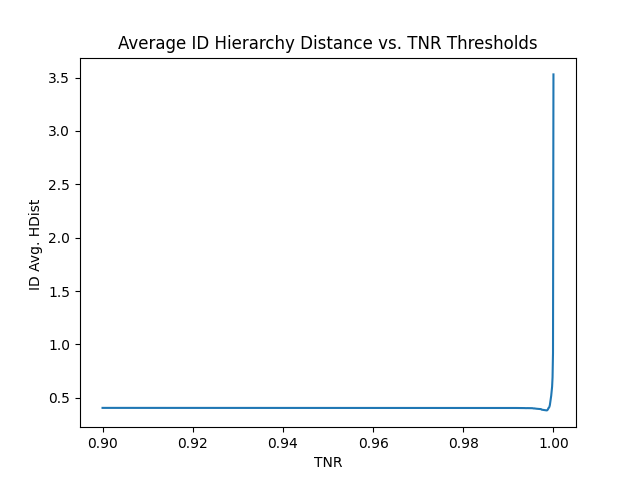

<IPython.core.display.Javascript object>


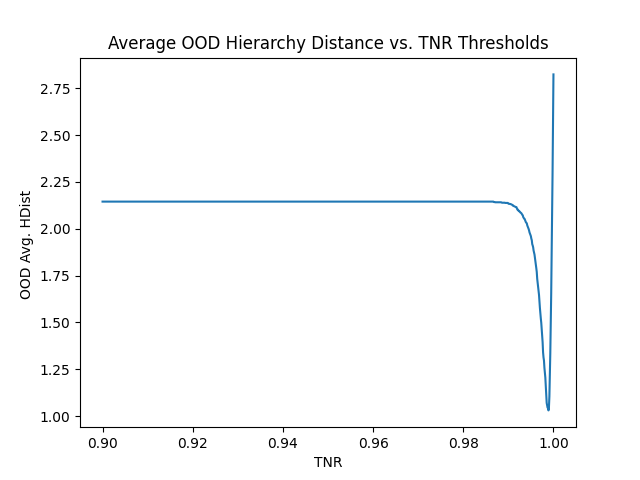

<IPython.core.display.Javascript object>


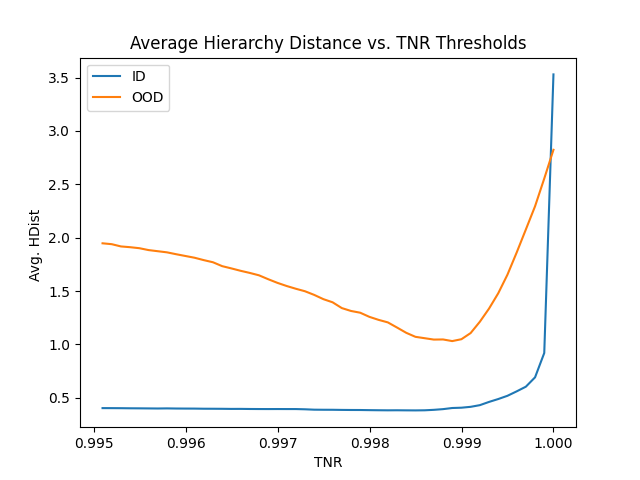

<IPython.core.display.Javascript object>


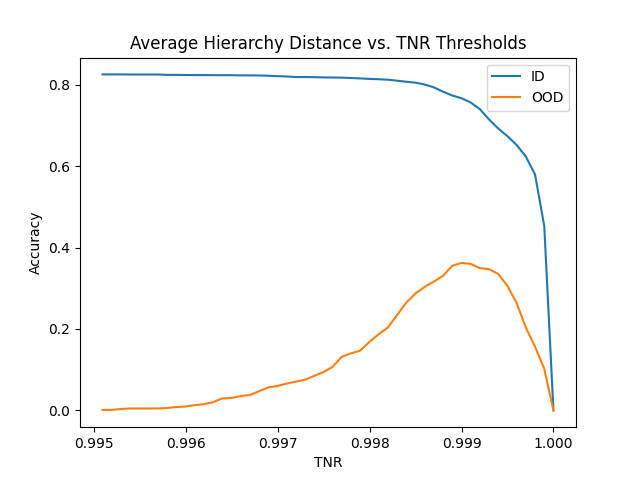

In [374]:
tnr = np.linspace(.9, 1., 1000)
fig = plt.figure()
plt.plot(res[2][950:995], res[5][950:995])
plt.plot(ressynpred[2][:98], ressynpred[5][:98])
plt.ylabel('OOD Avg. HDist ')
plt.xlabel('ID Avg. HDist ')
plt.legend(['Path Prob', 'Synset PP'])
plt.title('Average ID vs. OOD Hierarchy Distance across TNR Thresholds')
plt.show()


fig = plt.figure()
plt.plot(tnr,res[2])
plt.ylabel('ID Avg. HDist ')
plt.xlabel('TNR')
plt.title('Average ID Hierarchy Distance vs. TNR Thresholds')
plt.show()
fig = plt.figure()
plt.plot(tnr, res[5])
plt.ylabel('OOD Avg. HDist ')
plt.xlabel('TNR')
plt.title('Average OOD Hierarchy Distance vs. TNR Thresholds')
plt.show()

fig = plt.figure()
plt.plot(tnr[950:], res[2][950:], tnr[950:], res[5][950:])
plt.ylabel('Avg. HDist ')
plt.xlabel('TNR')
plt.legend(['ID', 'OOD'])
plt.title('Average Hierarchy Distance vs. TNR Thresholds')
plt.show()
         
fig = plt.figure()
plt.plot(tnr[950:], res[0][950:], tnr[950:], res[3][950:])
plt.ylabel('Accuracy')
plt.xlabel('TNR')
plt.legend(['ID', 'OOD'])
plt.title('Average Hierarchy Distance vs. TNR Thresholds')
plt.show()

In [336]:
res[2][990:]

[0.41445783132530123,
 0.43012048192771085,
 0.4604819277108434,
 0.4874698795180723,
 0.5178313253012048,
 0.5592771084337349,
 0.603132530120482,
 0.690843373493976,
 0.9190361445783133,
 3.5301204819277108]

    TNR  | ID     | OOD 
    90   | 0.420 | 1.0667
    95   | 0.4085 | 1.0133
    97   | 0.4045 | 0.8400
    98   | 0.4208 | 0.6933
    99   | 0.4520 | 0.5866
    995  | 0.5600 | 0.5000
    997  | 0.6845 | 0.4533
    999  | 1.1922 | 0.7600
    9999 | 3.8866 | 2.6667

<IPython.core.display.Javascript object>


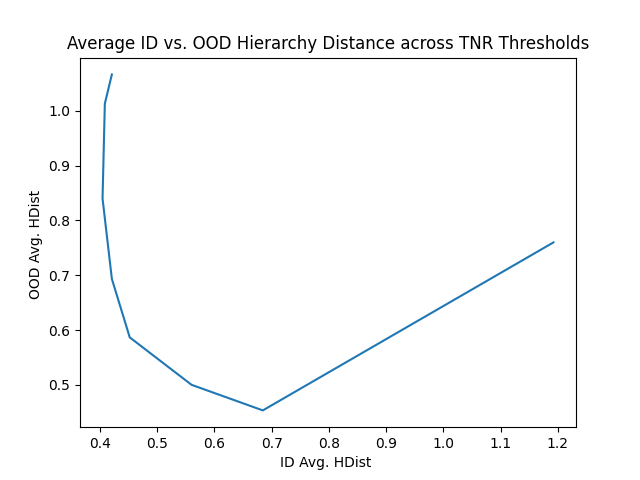

<IPython.core.display.Javascript object>


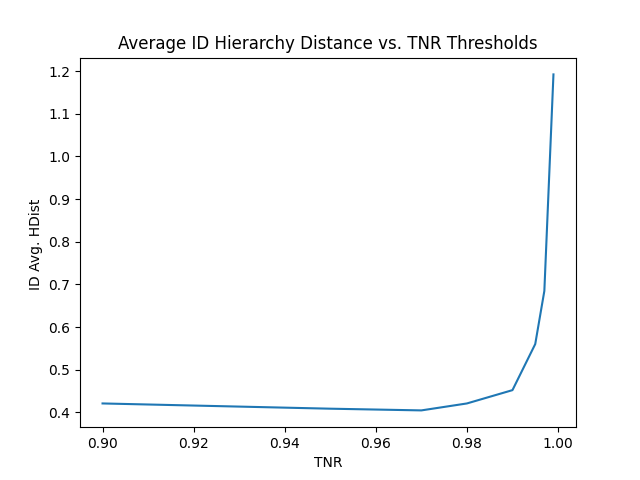

<IPython.core.display.Javascript object>


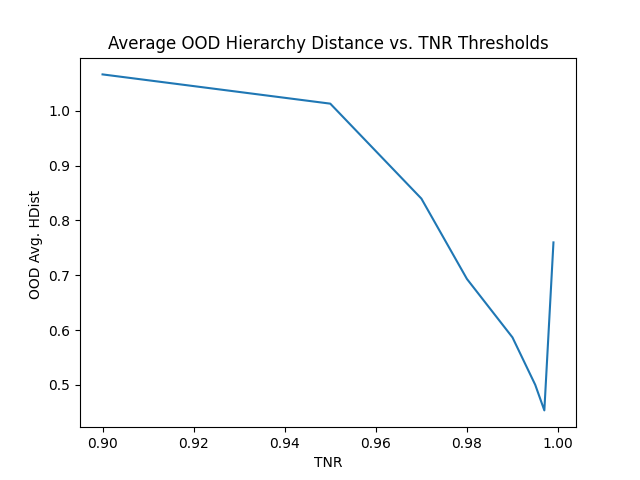

In [219]:
# idhdist =  [0.4208, 0.4085, 0.4045, 0.4208, 0.4520, 0.5600, 0.6845, 1.1922]#, 3.8866]
# oodhdist = [1.0667, 1.0133, 0.8400, 0.6933, 0.5866, 0.5000, 0.4533, 0.7600]#, 2.6667]
# tnr =      [.90,    .95,    .97,    .98,    .99,    .995,   .997,    .999]
fig = plt.figure()
plt.plot(idhdist, oodhdist)
plt.ylabel('OOD Avg. HDist ')
plt.xlabel('ID Avg. HDist ')
plt.title('Average ID vs. OOD Hierarchy Distance across TNR Thresholds')
plt.show()
fig = plt.figure()
plt.plot(tnr,idhdist)
plt.ylabel('ID Avg. HDist ')
plt.xlabel('TNR')
plt.title('Average ID Hierarchy Distance vs. TNR Thresholds')
plt.show()
fig = plt.figure()
plt.plot(tnr, oodhdist)
plt.ylabel('OOD Avg. HDist ')
plt.xlabel('TNR')
plt.title('Average OOD Hierarchy Distance vs. TNR Thresholds')
plt.show()

In [143]:
plot_cmat(HPA.result_hierarchy_distances(), tnr=0.99)
plot_cmat(HPAOOD.result_hierarchy_distances(), "OOD", tnr=0.99)

NameError: name 'plot_cmat' is not defined

## Calculate TNR Thresh Distance

In [387]:
from importlib import reload

In [47]:
reload(hierarchy_inference)
reload(hierarchy_metrics)

<module 'hierarchy_metrics' from '/home/rwl93/duke/CEI/hierarchical-ood/hierarchy_metrics.py'>

In [109]:
hdist_gt_val, hdist_pred_val = hierarchy_metrics.calc_hdists(
    val_ml.clone().detach().cpu(),
    val_act.clone().detach().cpu(),
    (val_tnr95_bpred_ml, val_tnr95_bpred_act),
    id_hierarchy, is_pred_ml=True)
hdist_gt_ood, hdist_pred_ood = hierarchy_metrics.calc_hdists(
    ood_ml.clone().detach().cpu(),
    ood_act.clone().detach().cpu(),
    (ood_tnr95_bpred_ml,ood_tnr95_bpred_act),
    id_hierarchy, is_pred_ml=True)

No Prediction 0
No Prediction 0


In [50]:
val_cmat = confusion_matrix(hdist_gt_val, hdist_pred_val)
ood_cmat = confusion_matrix(hdist_gt_ood, hdist_pred_ood)

In [564]:
def plot_cmat(cmat, dset='Validation', tnr=0.95):
    num_correct = cmat[0,0]
    cmat[0,0] = -1
    vmax = np.max(cmat)
    cmat[0,0] = 10000
    vmin = np.min(cmat)
    cmat[0,0] = num_correct

    cmap_mask = np.ones((*cmat.shape,), dtype=bool)
    cmap_mask[0, 0] = False

    f, ax = plt.subplots()
    ax = sns.heatmap(cmat, annot=True, fmt='d', cmap='Blues', vmin=vmin, vmax=vmax, ax=ax)
    ax.axhline(y=0, color='k',linewidth=1)
    ax.axhline(y=cmat.shape[1], color='k',linewidth=2)
    ax.axvline(x=0, color='k',linewidth=1)
    ax.axvline(x=cmat.shape[0], color='k',linewidth=2)
    # sns.heatmap(val_cmat, annot=True, mask=cmap_mask, cmap=None,)

    plt.ylabel("Groundtruth Hierarchy Distance")
    plt.xlabel("Prediction Hierarchy Distance")
    plt.title(f'{dset} Set Hierarchy Distances TNR={tnr:.0%}')

<IPython.core.display.Javascript object>


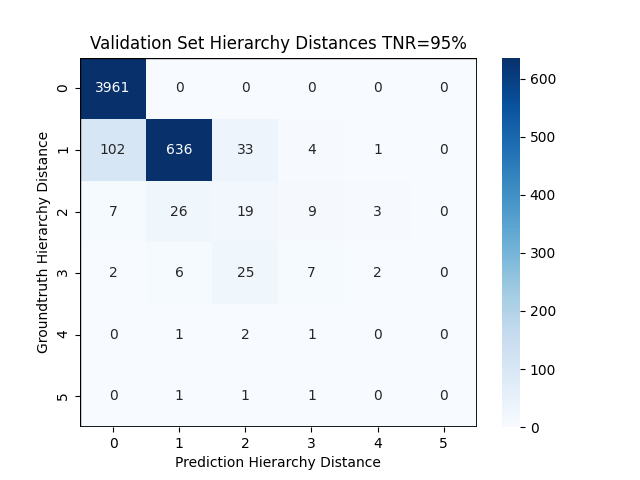

In [98]:
plot_cmat(val_cmat)

<IPython.core.display.Javascript object>


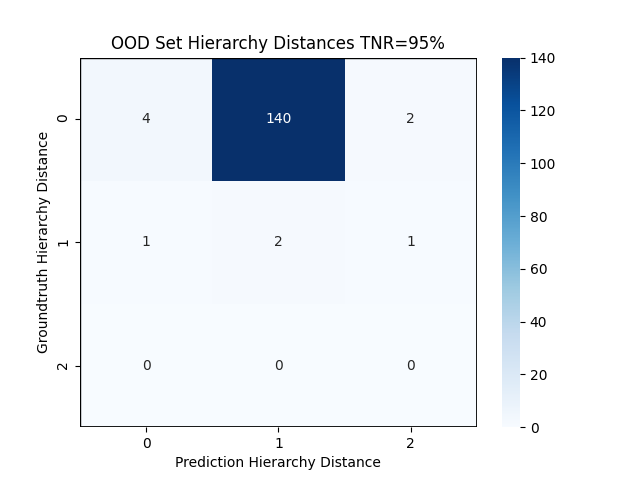

In [99]:
plot_cmat(ood_cmat, 'OOD')

<IPython.core.display.Javascript object>


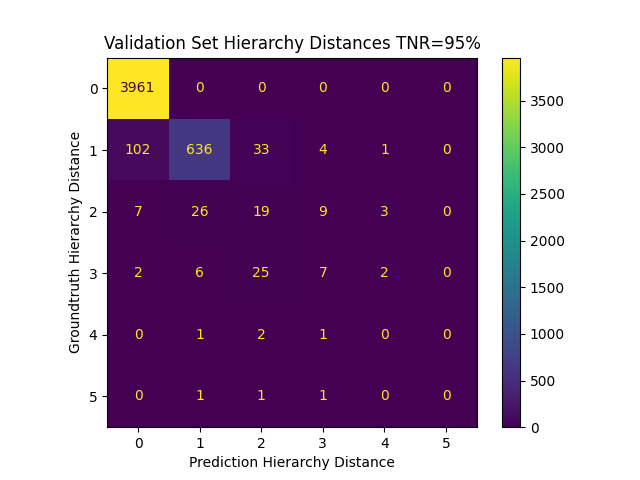

In [55]:
val_cmat_disp = ConfusionMatrixDisplay(confusion_matrix=val_cmat)
# val_cmat_disp = ConfusionMatrixDisplay(confusion_matrix=val_cmat, display_labels=np.arange(0, val_cmat.shape[0]-1))
# val_cmat_disp = ConfusionMatrixDisplay(confusion_matrix=val_cmat, display_labels=np.arange(-1, val_cmat.shape[0]-1))
val_cmat_disp.plot()
plt.ylabel("Groundtruth Hierarchy Distance")
plt.xlabel("Prediction Hierarchy Distance")
plt.title("Validation Set Hierarchy Distances TNR=95%")
plt.show()

<IPython.core.display.Javascript object>


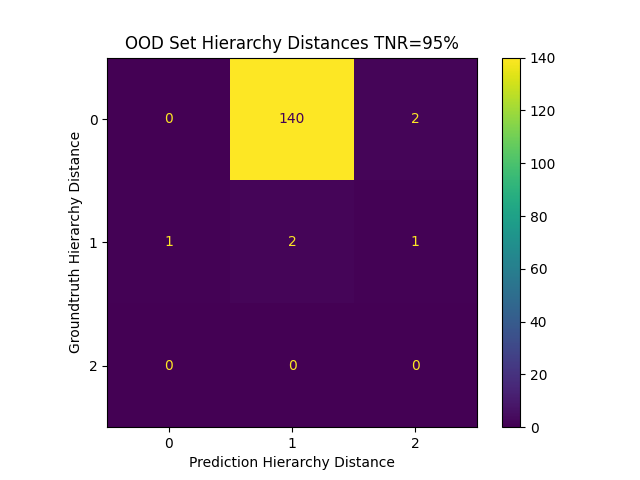

In [45]:
ood_cmat_disp = ConfusionMatrixDisplay(confusion_matrix=ood_cmat[1:,1:], display_labels=np.arange(0, ood_cmat.shape[0]-1))
ood_cmat_disp.plot()
plt.ylabel("Groundtruth Hierarchy Distance")
plt.xlabel("Prediction Hierarchy Distance")
plt.title("OOD Set Hierarchy Distances TNR=95%")
plt.show()

# Performance vs depth

In [9]:
def get_synset_depths(hierarchy):
    depths = np.zeros((len(hierarchy.synset_bounds),))
    for i, bound in enumerate(hierarchy.synset_bounds):
        class_wnid = hierarchy.class_list[bound]
        class_parents = hierarchy.class_parents[class_wnid]
        depths[i] = len(class_parents)
    return depths
ph_depths = get_synset_depths(pruned_hierarchy_fine)

Text(0, 0.5, 'Accuracy')

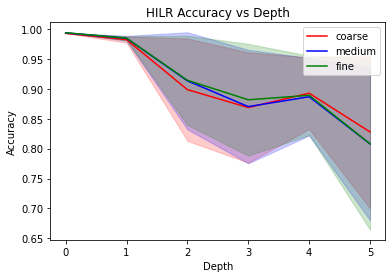

In [58]:
def plot_bydepth(depths, dat, color):
    bydepth = int(depths.max()+1)*[np.empty((0,))]
    for i, d in enumerate(dat):
        curr_depth = int(depths[i])
        bydepth[curr_depth] = np.append(bydepth[curr_depth],d)
    bydepth_means = np.array([d.mean() for d in bydepth])
    bydepth_std = np.array([d.std() for d in bydepth])
    idxs = np.arange(depths.max()+1)
    plt.plot(idxs, bydepth_means, color)
    plt.fill_between(idxs,
                     bydepth_means-bydepth_std,
                     bydepth_means+bydepth_std,
                     color=color, alpha=.2)
fig = plt.figure() 
plot_bydepth(ph_depths_c, hilr_coarse['acc'], 'red')
plot_bydepth(ph_depths_m, hilr_medium['acc'], 'blue')
plot_bydepth(ph_depths_f, hilr_fine['acc'], 'green')
plt.legend(['coarse', 'medium', 'fine'])
plt.title('HILR Accuracy vs Depth')
plt.xlabel('Depth')
plt.ylabel('Accuracy')

Text(0, 0.5, 'AUROC')

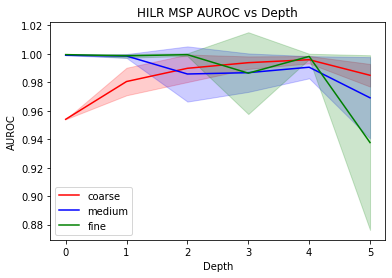

In [65]:
fig = plt.figure() 
plot_bydepth(ph_depths_c, hilr_coarse['ood'][0]['MSP']['AUROC'][1:-2], 'red')
plot_bydepth(ph_depths_m, hilr_medium['ood'][0]['MSP']['AUROC'][1:-2], 'blue')
plot_bydepth(ph_depths_f, hilr_fine['ood'][0]['MSP']['AUROC'][1:-2], 'green')
plt.legend(['coarse', 'medium', 'fine'])
plt.title('HILR MSP AUROC vs Depth')
plt.xlabel('Depth')
plt.ylabel('AUROC')

(1.0, 5.25)

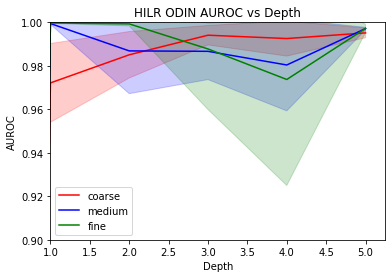

In [70]:
fig = plt.figure() 
plot_bydepth(ph_depths_c, hilr_coarse['ood'][0]['ODIN']['AUROC'][0:-2], 'red')
plot_bydepth(ph_depths_m, hilr_medium['ood'][0]['ODIN']['AUROC'][0:-2], 'blue')
plot_bydepth(ph_depths_f, hilr_fine['ood'][0]['ODIN']['AUROC'][0:-2], 'green')
plt.legend(['coarse', 'medium', 'fine'])
plt.title('HILR ODIN AUROC vs Depth')
plt.xlabel('Depth')
plt.ylabel('AUROC')
plt.ylim(.9, 1.)
plt.xlim(1)

(1.0, 5.25)

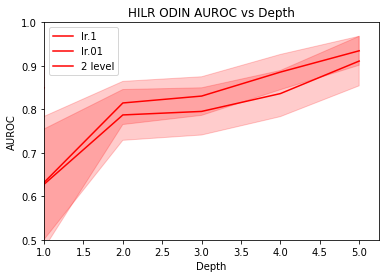

In [73]:
fig = plt.figure() 
plot_bydepth(ph_depths_c, cascade_coarse['ood'][0]['ODIN']['AUROC'][0:-2], 'red')
plot_bydepth(ph_depths_c, cascade_coarse_LRp01['ood'][0]['ODIN']['AUROC'][0:-2], 'red')
plot_bydepth(tl_depths_c, cascade_coarse_twolvl['ood'][0]['ODIN']['AUROC'][0:-2], 'red')
plt.legend(['lr.1', 'lr.01', '2 level'])
plt.title('HILR ODIN AUROC vs Depth')
plt.xlabel('Depth')
plt.ylabel('AUROC')
plt.ylim(.5, 1.)
plt.xlim(1)

In [62]:
hilr_coarse['ood'][0]

{'MSP': defaultdict(list,
             {'AUROC': [-1,
               0.9540329411764705,
               0.9902752941176468,
               0.9709082352941176,
               0.9813317647058825,
               0.9747952941176472,
               0.9995576470588237,
               0.9974882352941177,
               0.9864217054263567,
               0.9997058823529412,
               0.9973082352941177,
               0.9998729411764706,
               0.9948752941176472,
               0.9986211764705883,
               0.9962986842105264,
               0.9932329411764705,
               0.9973976470588236,
               0.9929317647058824,
               0.9770176470588235,
               0.9953976470588236,
               0.9921223529411766,
               0.9963152941176472,
               0.9928941176470589,
               0.9836329411764707,
               0.9924058823529411,
               0.9924433734939759,
               0.9191560595322467],
              'TNR': [-1,
         

# Performance vs hierarchy hyperparameter

In [90]:
hilr_coarse_msp_auroc = np.array(hilr_coarse['ood'][0]['MSP']['AUROC'][1:-2])
print('HILR Coarse MSP AUROC Mean: {} Std:{}'.format(hilr_coarse_msp_auroc.mean(), hilr_coarse_msp_auroc.std()))
print('HILR Coarse MSP AUROC min: {}'.format(hilr_coarse_msp_auroc.min()))
hilr_coarse_odin_auroc = np.array(hilr_coarse['ood'][0]['ODIN']['AUROC'][1:-2])
print('HILR Coarse ODIN AUROC Mean: {} Std:{}'.format(hilr_coarse_odin_auroc.mean(), hilr_coarse_odin_auroc.std()))
print('HILR Coarse ODIN AUROC min: {}'.format(hilr_coarse_odin_auroc.min()))

HILR Coarse MSP AUROC Mean: 0.9897850652544781 Std:0.010948811021538763
HILR Coarse MSP AUROC min: 0.9540329411764705
HILR Coarse ODIN AUROC Mean: 0.9897833806229551 Std:0.010949514778934799
HILR Coarse ODIN AUROC min: 0.9540313725490195


In [91]:
hilr_medium_msp_auroc = np.array(hilr_medium['ood'][0]['MSP']['AUROC'][1:-2])
print('HILR medium MSP AUROC Mean: {} Std:{}'.format(hilr_medium_msp_auroc.mean(), hilr_medium_msp_auroc.std()))
print('HILR medium MSP AUROC min: {}'.format(hilr_medium_msp_auroc.min()))
hilr_medium_odin_auroc = np.array(hilr_medium['ood'][0]['ODIN']['AUROC'][1:-2])
print('HILR medium ODIN AUROC Mean: {} Std:{}'.format(hilr_medium_odin_auroc.mean(), hilr_medium_odin_auroc.std()))
print('HILR medium ODIN AUROC min: {}'.format(hilr_medium_odin_auroc.min()))

HILR medium MSP AUROC Mean: 0.9872906834023323 Std:0.016700162177810486
HILR medium MSP AUROC min: 0.9405428571428571
HILR medium ODIN AUROC Mean: 0.9872903210053616 Std:0.016700665653567696
HILR medium ODIN AUROC min: 0.9405428571428571


In [92]:
hilr_fine_msp_auroc = np.array(hilr_fine['ood'][0]['MSP']['AUROC'][1:-2])
print('HILR fine MSP AUROC Mean: {} Std:{}'.format(hilr_fine_msp_auroc.mean(), hilr_fine_msp_auroc.std()))
print('HILR fine MSP AUROC min: {}'.format(hilr_fine_msp_auroc.min()))
hilr_fine_odin_auroc = np.array(hilr_fine['ood'][0]['ODIN']['AUROC'][1:-2])
print('HILR fine ODIN AUROC Mean: {} Std:{}'.format(hilr_fine_odin_auroc.mean(), hilr_fine_odin_auroc.std()))
print('HILR fine ODIN AUROC min: {}'.format(hilr_fine_odin_auroc.min()))

HILR fine MSP AUROC Mean: 0.989674838650946 Std:0.02896065122042395
HILR fine MSP AUROC min: 0.8762666666666667
HILR fine ODIN AUROC Mean: 0.9896734380907218 Std:0.028964144021208216
HILR fine ODIN AUROC min: 0.8762666666666667


In [76]:
hilr_medium

{'ood': ({'MSP': defaultdict(list,
               {'AUROC': [-1,
                 0.9990482758620689,
                 0.99986875,
                 0.9971885714285713,
                 0.99944,
                 0.99872,
                 0.9998095238095238,
                 0.9983428571428572,
                 0.9616857142857143,
                 0.99992,
                 0.996422857142857,
                 0.9725885714285714,
                 0.9439658119658119,
                 0.9882914285714286,
                 0.9896457142857144,
                 0.9961942857142857,
                 0.9973942857142857,
                 0.99624,
                 0.976778947368421,
                 0.9976742857142858,
                 0.9965828571428571,
                 0.9977371428571429,
                 0.9405428571428571,
                 0.9779428571428571,
                 0.9850971428571429,
                 0.9637142857142856,
                 0.9947999999999999,
                 0.99121142

In [77]:
hilr_fine

{'ood': ({'MSP': defaultdict(list,
               {'AUROC': [-1,
                 0.9995103448275862,
                 0.9999705882352941,
                 0.9973333333333333,
                 0.99976,
                 0.9998666666666667,
                 1.0,
                 0.9971466666666666,
                 0.9029,
                 0.99992,
                 0.9984,
                 0.9997733333333334,
                 0.9999720930232558,
                 0.9998266666666666,
                 0.9995733333333333,
                 1.0,
                 0.9997866666666666,
                 0.9998400000000001,
                 0.9993157894736842,
                 0.9960533333333333,
                 0.9953066666666666,
                 0.9990666666666667,
                 0.8762666666666667,
                 0.9967466666666667,
                 0.99936,
                 0.9998933333333333,
                 0.9974666666666667,
                 0.9985066666666667,
                 0.9593

In [78]:
cascade_coarse

{'ood': ({'MSP': defaultdict(list,
               {'AUROC': [-1,
                 0.7791027450980392,
                 0.57982,
                 0.7723952941176471,
                 0.8240235294117648,
                 0.77,
                 0.8831200000000001,
                 0.7293141176470588,
                 0.739466046511628,
                 0.8400635294117648,
                 0.8071623529411766,
                 0.9095247058823529,
                 0.8102117647058823,
                 0.7535341176470588,
                 0.8042013157894736,
                 0.8448094117647058,
                 0.9335482352941178,
                 0.8164705882352943,
                 0.8501117647058825,
                 0.8212658823529412,
                 0.7533458823529411,
                 0.8055294117647059,
                 0.6839152941176472,
                 0.7764705882352941,
                 0.8875882352941176,
                 0.6733020552799434,
                 0.7498177179305456]

In [79]:
cascade_coarse_LRp01

{'ood': ({'MSP': defaultdict(list,
               {'AUROC': [-1,
                 0.7500141176470588,
                 0.6005517647058823,
                 0.6957788235294117,
                 0.8153270588235295,
                 0.7727623529411765,
                 0.8718917647058824,
                 0.7046976470588235,
                 0.7311317829457364,
                 0.7235694117647058,
                 0.7535388235294117,
                 0.8734635294117645,
                 0.7018541176470589,
                 0.7011294117647059,
                 0.8362171052631577,
                 0.781670588235294,
                 0.9308,
                 0.7569599999999999,
                 0.7706000000000001,
                 0.7893788235294118,
                 0.7093082352941176,
                 0.7583011764705883,
                 0.6537741176470588,
                 0.7720141176470587,
                 0.8685882352941174,
                 0.47413834160170093,
                 0.723

In [80]:
cascade_coarse_twolvl

{'ood': ({'MSP': defaultdict(list,
               {'AUROC': [0.6490008032128514,
                 0.7807670588235295,
                 0.8222211764705882,
                 0.7769458823529412,
                 0.8913129411764705,
                 0.7499011764705883,
                 0.8893458823529412,
                 0.7771199999999999,
                 0.7306541176470588,
                 0.9505976470588234,
                 0.7965129411764708,
                 0.8346176470588236,
                 0.8047576470588235,
                 0.7511717647058824,
                 0.8021505882352942,
                 0.6622164705882354,
                 0.7887058823529413,
                 0.8674705882352941,
                 0.4387223245924876,
                 0.6979163713678243],
                'TNR': [0.08266666666666667,
                 0.20352941176470585,
                 0.2905882352941176,
                 0.1588235294117647,
                 0.2647058823529411,
                 0.13

In [81]:
soft_coarse

{'ood': {'MSP': defaultdict(list,
              {'AUROC': [0.9101046066619418],
               'TNR': [0.5705882352941176],
               'AUOUT': [0.6939882039567155]}),
  'ODIN': defaultdict(list,
              {'AUROC': [0.9368507441530829],
               'TNR': [0.7247058823529412],
               'AUOUT': [0.7478364384898043]})},
 'acc': tensor([0.8166, 0.9704]),
 'top1': tensor(0.8166),
 'pred': tensor(0.8166)}

Text(0, 0.5, 'Hierarchy info')

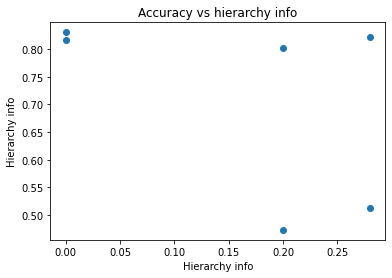

In [94]:
legend = ['']
acc_scores = [.8166, .8308, .5123, .8222, .4728, .8029]
x = [0., 0., .28, .28, .2, .2]
plt.scatter(x, acc_scores)
plt.title('Accuracy vs hierarchy info')
plt.xlabel('Accuracy')
plt.ylabel('Hierarchy info')

Text(0, 0.5, 'Hierarchy info')

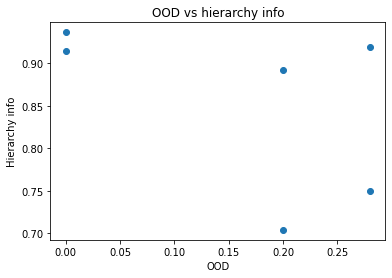

In [95]:
legend = ['']
acc_scores = [.9364, .9146, .7498, .9192, .7042, .8915]
x = [0., 0., .28, .28, .2, .2]
plt.scatter(x, acc_scores)
plt.title('OOD vs hierarchy info')
plt.xlabel('OOD')
plt.ylabel('Hierarchy info')